In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 0.25,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_025_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1543658, 828)
(1543658, 8)
validation
(205888, 828)
(205888, 8)
test
(205670, 828)
(205670, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/155 [..............................] - ETA: 3:32 - loss: 2.0879 - STD: 0.0307 - MAE: 0.2183

  4/155 [..............................] - ETA: 2s - loss: 2.0100 - STD: 0.0791 - MAE: 0.2087  

  7/155 [>.............................] - ETA: 2s - loss: 1.9944 - STD: 0.0851 - MAE: 0.2074

 10/155 [>.............................] - ETA: 2s - loss: 1.9842 - STD: 0.0760 - MAE: 0.2085

 13/155 [=>............................] - ETA: 2s - loss: 1.9780 - STD: 0.0717 - MAE: 0.2090

 16/155 [==>...........................] - ETA: 2s - loss: 1.9722 - STD: 0.0721 - MAE: 0.2088

 19/155 [==>...........................] - ETA: 2s - loss: 1.9674 - STD: 0.0740 - MAE: 0.2083

 22/155 [===>..........................] - ETA: 2s - loss: 1.9642 - STD: 0.0748 - MAE: 0.2081

 25/155 [===>..........................] - ETA: 2s - loss: 1.9615 - STD: 0.0744 - MAE: 0.2081

 28/155 [====>.........................] - ETA: 2s - loss: 1.9568 - STD: 0.0735 - MAE: 0.2081

 31/155 [=====>........................] - ETA: 2s - loss: 1.9508 - STD: 0.0728 - MAE: 0.2080

 34/155 [=====>........................] - ETA: 2s - loss: 1.9428 - STD: 0.0730 - MAE: 0.2077

 38/155 [======>.......................] - ETA: 2s - loss: 1.9306 - STD: 0.0748 - MAE: 0.2070

 42/155 [=======>......................] - ETA: 1s - loss: 1.9173 - STD: 0.0769 - MAE: 0.2063

 46/155 [=======>......................] - ETA: 1s - loss: 1.9033 - STD: 0.0785 - MAE: 0.2056

 49/155 [========>.....................] - ETA: 1s - loss: 1.8919 - STD: 0.0796 - MAE: 0.2050

 52/155 [=========>....................] - ETA: 1s - loss: 1.8800 - STD: 0.0810 - MAE: 0.2044

 55/155 [=========>....................] - ETA: 1s - loss: 1.8668 - STD: 0.0824 - MAE: 0.2037

 59/155 [==========>...................] - ETA: 1s - loss: 1.8479 - STD: 0.0843 - MAE: 0.2028

 62/155 [===========>..................] - ETA: 1s - loss: 1.8334 - STD: 0.0861 - MAE: 0.2019

 65/155 [===========>..................] - ETA: 1s - loss: 1.8191 - STD: 0.0879 - MAE: 0.2011

 68/155 [============>.................] - ETA: 1s - loss: 1.8054 - STD: 0.0900 - MAE: 0.2002

 71/155 [============>.................] - ETA: 1s - loss: 1.7925 - STD: 0.0919 - MAE: 0.1993

 75/155 [=============>................] - ETA: 1s - loss: 1.7762 - STD: 0.0943 - MAE: 0.1982

 79/155 [==============>...............] - ETA: 1s - loss: 1.7608 - STD: 0.0967 - MAE: 0.1971

 83/155 [===============>..............] - ETA: 1s - loss: 1.7464 - STD: 0.0988 - MAE: 0.1962

 87/155 [===============>..............] - ETA: 1s - loss: 1.7331 - STD: 0.1007 - MAE: 0.1953

 90/155 [================>.............] - ETA: 1s - loss: 1.7235 - STD: 0.1021 - MAE: 0.1946

 93/155 [=================>............] - ETA: 1s - loss: 1.7141 - STD: 0.1035 - MAE: 0.1939

 97/155 [=================>............] - ETA: 0s - loss: 1.7021 - STD: 0.1053 - MAE: 0.1931

101/155 [==================>...........] - ETA: 0s - loss: 1.6908 - STD: 0.1070 - MAE: 0.1923

105/155 [===================>..........] - ETA: 0s - loss: 1.6799 - STD: 0.1086 - MAE: 0.1915

109/155 [====================>.........] - ETA: 0s - loss: 1.6696 - STD: 0.1101 - MAE: 0.1908

112/155 [====================>.........] - ETA: 0s - loss: 1.6620 - STD: 0.1112 - MAE: 0.1902

115/155 [=====================>........] - ETA: 0s - loss: 1.6546 - STD: 0.1122 - MAE: 0.1897

118/155 [=====================>........] - ETA: 0s - loss: 1.6492 - STD: 0.1133 - MAE: 0.1892

121/155 [======================>.......] - ETA: 0s - loss: 1.6421 - STD: 0.1144 - MAE: 0.1887

124/155 [=======================>......] - ETA: 0s - loss: 1.6355 - STD: 0.1153 - MAE: 0.1882

128/155 [=======================>......] - ETA: 0s - loss: 1.6269 - STD: 0.1166 - MAE: 0.1875

132/155 [========================>.....] - ETA: 0s - loss: 1.6183 - STD: 0.1178 - MAE: 0.1869

136/155 [=========================>....] - ETA: 0s - loss: 1.6101 - STD: 0.1190 - MAE: 0.1863

140/155 [==========================>...] - ETA: 0s - loss: 1.6025 - STD: 0.1202 - MAE: 0.1857

143/155 [==========================>...] - ETA: 0s - loss: 1.5968 - STD: 0.1210 - MAE: 0.1853

147/155 [===========================>..] - ETA: 0s - loss: 1.5893 - STD: 0.1221 - MAE: 0.1847

151/155 [============================>.] - ETA: 0s - loss: 1.5822 - STD: 0.1232 - MAE: 0.1842

154/155 [============================>.] - ETA: 0s - loss: 1.5768 - STD: 0.1239 - MAE: 0.1838

155/155 [==============================] - 5s 27ms/step - loss: 1.5751 - STD: 0.1242 - MAE: 0.1836 - val_loss: 1.3405 - val_STD: 0.1498 - val_MAE: 0.1671


Epoch 2/10000


  1/155 [..............................] - ETA: 7s - loss: 1.3036 - STD: 0.1623 - MAE: 0.1633

  4/155 [..............................] - ETA: 2s - loss: 1.3035 - STD: 0.1630 - MAE: 0.1629

  7/155 [>.............................] - ETA: 2s - loss: 1.3012 - STD: 0.1643 - MAE: 0.1624

 10/155 [>.............................] - ETA: 2s - loss: 1.3069 - STD: 0.1644 - MAE: 0.1627

 13/155 [=>............................] - ETA: 2s - loss: 1.3091 - STD: 0.1652 - MAE: 0.1625

 17/155 [==>...........................] - ETA: 2s - loss: 1.3065 - STD: 0.1653 - MAE: 0.1624

 20/155 [==>...........................] - ETA: 2s - loss: 1.3068 - STD: 0.1655 - MAE: 0.1623

 23/155 [===>..........................] - ETA: 2s - loss: 1.3031 - STD: 0.1655 - MAE: 0.1622

 26/155 [====>.........................] - ETA: 2s - loss: 1.3022 - STD: 0.1657 - MAE: 0.1620

 29/155 [====>.........................] - ETA: 2s - loss: 1.3002 - STD: 0.1658 - MAE: 0.1619

 32/155 [=====>........................] - ETA: 2s - loss: 1.2984 - STD: 0.1663 - MAE: 0.1617

 35/155 [=====>........................] - ETA: 2s - loss: 1.2974 - STD: 0.1663 - MAE: 0.1616

 39/155 [======>.......................] - ETA: 2s - loss: 1.2958 - STD: 0.1665 - MAE: 0.1615

 43/155 [=======>......................] - ETA: 1s - loss: 1.2936 - STD: 0.1669 - MAE: 0.1612

 46/155 [=======>......................] - ETA: 1s - loss: 1.2926 - STD: 0.1670 - MAE: 0.1611

 50/155 [========>.....................] - ETA: 1s - loss: 1.2906 - STD: 0.1673 - MAE: 0.1609

 53/155 [=========>....................] - ETA: 1s - loss: 1.2885 - STD: 0.1674 - MAE: 0.1608

 57/155 [==========>...................] - ETA: 1s - loss: 1.2861 - STD: 0.1677 - MAE: 0.1606

 60/155 [==========>...................] - ETA: 1s - loss: 1.2842 - STD: 0.1679 - MAE: 0.1604

 64/155 [===========>..................] - ETA: 1s - loss: 1.2824 - STD: 0.1682 - MAE: 0.1603

 67/155 [===========>..................] - ETA: 1s - loss: 1.2811 - STD: 0.1684 - MAE: 0.1601

 71/155 [============>.................] - ETA: 1s - loss: 1.2794 - STD: 0.1686 - MAE: 0.1600

 74/155 [=============>................] - ETA: 1s - loss: 1.2778 - STD: 0.1689 - MAE: 0.1598

 78/155 [==============>...............] - ETA: 1s - loss: 1.2753 - STD: 0.1692 - MAE: 0.1596

 81/155 [==============>...............] - ETA: 1s - loss: 1.2739 - STD: 0.1694 - MAE: 0.1594

 84/155 [===============>..............] - ETA: 1s - loss: 1.2726 - STD: 0.1697 - MAE: 0.1593

 87/155 [===============>..............] - ETA: 1s - loss: 1.2714 - STD: 0.1699 - MAE: 0.1592

 91/155 [================>.............] - ETA: 1s - loss: 1.2700 - STD: 0.1701 - MAE: 0.1590

 94/155 [=================>............] - ETA: 1s - loss: 1.2687 - STD: 0.1703 - MAE: 0.1589

 97/155 [=================>............] - ETA: 0s - loss: 1.2674 - STD: 0.1705 - MAE: 0.1588

101/155 [==================>...........] - ETA: 0s - loss: 1.2660 - STD: 0.1707 - MAE: 0.1586

104/155 [===================>..........] - ETA: 0s - loss: 1.2650 - STD: 0.1709 - MAE: 0.1585

108/155 [===================>..........] - ETA: 0s - loss: 1.2637 - STD: 0.1712 - MAE: 0.1584

111/155 [====================>.........] - ETA: 0s - loss: 1.2628 - STD: 0.1714 - MAE: 0.1583

114/155 [=====================>........] - ETA: 0s - loss: 1.2620 - STD: 0.1715 - MAE: 0.1582

117/155 [=====================>........] - ETA: 0s - loss: 1.2609 - STD: 0.1716 - MAE: 0.1581

120/155 [======================>.......] - ETA: 0s - loss: 1.2598 - STD: 0.1718 - MAE: 0.1580

124/155 [=======================>......] - ETA: 0s - loss: 1.2585 - STD: 0.1720 - MAE: 0.1579

127/155 [=======================>......] - ETA: 0s - loss: 1.2578 - STD: 0.1721 - MAE: 0.1578

130/155 [========================>.....] - ETA: 0s - loss: 1.2570 - STD: 0.1723 - MAE: 0.1577

133/155 [========================>.....] - ETA: 0s - loss: 1.2561 - STD: 0.1724 - MAE: 0.1576

137/155 [=========================>....] - ETA: 0s - loss: 1.2550 - STD: 0.1726 - MAE: 0.1575

141/155 [==========================>...] - ETA: 0s - loss: 1.2539 - STD: 0.1728 - MAE: 0.1574

144/155 [==========================>...] - ETA: 0s - loss: 1.2528 - STD: 0.1729 - MAE: 0.1573

148/155 [===========================>..] - ETA: 0s - loss: 1.2516 - STD: 0.1731 - MAE: 0.1572

152/155 [============================>.] - ETA: 0s - loss: 1.2502 - STD: 0.1733 - MAE: 0.1570

155/155 [==============================] - 3s 19ms/step - loss: 1.2493 - STD: 0.1734 - MAE: 0.1570 - val_loss: 1.2575 - val_STD: 0.1694 - val_MAE: 0.1578


Epoch 3/10000


  1/155 [..............................] - ETA: 8s - loss: 1.2096 - STD: 0.1796 - MAE: 0.1530

  4/155 [..............................] - ETA: 2s - loss: 1.1933 - STD: 0.1814 - MAE: 0.1517

  7/155 [>.............................] - ETA: 2s - loss: 1.1938 - STD: 0.1813 - MAE: 0.1517

 10/155 [>.............................] - ETA: 2s - loss: 1.1949 - STD: 0.1811 - MAE: 0.1518

 14/155 [=>............................] - ETA: 2s - loss: 1.1958 - STD: 0.1812 - MAE: 0.1518

 17/155 [==>...........................] - ETA: 2s - loss: 1.1952 - STD: 0.1810 - MAE: 0.1519

 21/155 [===>..........................] - ETA: 2s - loss: 1.1922 - STD: 0.1813 - MAE: 0.1516

 25/155 [===>..........................] - ETA: 2s - loss: 1.1906 - STD: 0.1813 - MAE: 0.1515

 29/155 [====>.........................] - ETA: 2s - loss: 1.1908 - STD: 0.1814 - MAE: 0.1515

 32/155 [=====>........................] - ETA: 2s - loss: 1.1903 - STD: 0.1815 - MAE: 0.1514

 36/155 [=====>........................] - ETA: 2s - loss: 1.1894 - STD: 0.1818 - MAE: 0.1513

 39/155 [======>.......................] - ETA: 1s - loss: 1.1888 - STD: 0.1819 - MAE: 0.1512

 42/155 [=======>......................] - ETA: 1s - loss: 1.1887 - STD: 0.1819 - MAE: 0.1512

 45/155 [=======>......................] - ETA: 1s - loss: 1.1891 - STD: 0.1821 - MAE: 0.1512

 48/155 [========>.....................] - ETA: 1s - loss: 1.1889 - STD: 0.1820 - MAE: 0.1512

 51/155 [========>.....................] - ETA: 1s - loss: 1.1888 - STD: 0.1822 - MAE: 0.1511

 55/155 [=========>....................] - ETA: 1s - loss: 1.1881 - STD: 0.1822 - MAE: 0.1511

 59/155 [==========>...................] - ETA: 1s - loss: 1.1872 - STD: 0.1822 - MAE: 0.1510

 62/155 [===========>..................] - ETA: 1s - loss: 1.1863 - STD: 0.1823 - MAE: 0.1510

 65/155 [===========>..................] - ETA: 1s - loss: 1.1859 - STD: 0.1824 - MAE: 0.1509

 68/155 [============>.................] - ETA: 1s - loss: 1.1851 - STD: 0.1824 - MAE: 0.1509

 72/155 [============>.................] - ETA: 1s - loss: 1.1845 - STD: 0.1826 - MAE: 0.1508

 75/155 [=============>................] - ETA: 1s - loss: 1.1845 - STD: 0.1827 - MAE: 0.1507

 78/155 [==============>...............] - ETA: 1s - loss: 1.1848 - STD: 0.1828 - MAE: 0.1507

 81/155 [==============>...............] - ETA: 1s - loss: 1.1842 - STD: 0.1829 - MAE: 0.1507

 85/155 [===============>..............] - ETA: 1s - loss: 1.1833 - STD: 0.1829 - MAE: 0.1506

 89/155 [================>.............] - ETA: 1s - loss: 1.1825 - STD: 0.1830 - MAE: 0.1505

 92/155 [================>.............] - ETA: 1s - loss: 1.1818 - STD: 0.1830 - MAE: 0.1505

 96/155 [=================>............] - ETA: 0s - loss: 1.1812 - STD: 0.1831 - MAE: 0.1505

100/155 [==================>...........] - ETA: 0s - loss: 1.1802 - STD: 0.1832 - MAE: 0.1504

104/155 [===================>..........] - ETA: 0s - loss: 1.1794 - STD: 0.1833 - MAE: 0.1503

107/155 [===================>..........] - ETA: 0s - loss: 1.1789 - STD: 0.1834 - MAE: 0.1503

111/155 [====================>.........] - ETA: 0s - loss: 1.1779 - STD: 0.1835 - MAE: 0.1502

115/155 [=====================>........] - ETA: 0s - loss: 1.1775 - STD: 0.1836 - MAE: 0.1501

119/155 [======================>.......] - ETA: 0s - loss: 1.1771 - STD: 0.1837 - MAE: 0.1500

122/155 [======================>.......] - ETA: 0s - loss: 1.1765 - STD: 0.1838 - MAE: 0.1500

126/155 [=======================>......] - ETA: 0s - loss: 1.1763 - STD: 0.1839 - MAE: 0.1500

130/155 [========================>.....] - ETA: 0s - loss: 1.1759 - STD: 0.1839 - MAE: 0.1499

133/155 [========================>.....] - ETA: 0s - loss: 1.1756 - STD: 0.1840 - MAE: 0.1499

137/155 [=========================>....] - ETA: 0s - loss: 1.1750 - STD: 0.1840 - MAE: 0.1498

140/155 [==========================>...] - ETA: 0s - loss: 1.1746 - STD: 0.1841 - MAE: 0.1498

144/155 [==========================>...] - ETA: 0s - loss: 1.1740 - STD: 0.1842 - MAE: 0.1497

148/155 [===========================>..] - ETA: 0s - loss: 1.1738 - STD: 0.1843 - MAE: 0.1497

152/155 [============================>.] - ETA: 0s - loss: 1.1732 - STD: 0.1844 - MAE: 0.1496

155/155 [==============================] - 3s 19ms/step - loss: 1.1727 - STD: 0.1844 - MAE: 0.1496 - val_loss: 1.2250 - val_STD: 0.1773 - val_MAE: 0.1544


Epoch 4/10000


  1/155 [..............................] - ETA: 7s - loss: 1.1531 - STD: 0.1838 - MAE: 0.1489

  4/155 [..............................] - ETA: 2s - loss: 1.1469 - STD: 0.1868 - MAE: 0.1476

  7/155 [>.............................] - ETA: 2s - loss: 1.1437 - STD: 0.1872 - MAE: 0.1472

 11/155 [=>............................] - ETA: 2s - loss: 1.1454 - STD: 0.1873 - MAE: 0.1472

 15/155 [=>............................] - ETA: 2s - loss: 1.1454 - STD: 0.1874 - MAE: 0.1472

 19/155 [==>...........................] - ETA: 2s - loss: 1.1449 - STD: 0.1875 - MAE: 0.1471

 23/155 [===>..........................] - ETA: 2s - loss: 1.1426 - STD: 0.1879 - MAE: 0.1469

 26/155 [====>.........................] - ETA: 2s - loss: 1.1413 - STD: 0.1880 - MAE: 0.1468

 29/155 [====>.........................] - ETA: 2s - loss: 1.1401 - STD: 0.1881 - MAE: 0.1467

 33/155 [=====>........................] - ETA: 2s - loss: 1.1387 - STD: 0.1883 - MAE: 0.1465

 36/155 [=====>........................] - ETA: 1s - loss: 1.1384 - STD: 0.1883 - MAE: 0.1465

 40/155 [======>.......................] - ETA: 1s - loss: 1.1383 - STD: 0.1885 - MAE: 0.1464

 44/155 [=======>......................] - ETA: 1s - loss: 1.1378 - STD: 0.1885 - MAE: 0.1464

 47/155 [========>.....................] - ETA: 1s - loss: 1.1369 - STD: 0.1886 - MAE: 0.1463

 51/155 [========>.....................] - ETA: 1s - loss: 1.1364 - STD: 0.1887 - MAE: 0.1462

 54/155 [=========>....................] - ETA: 1s - loss: 1.1361 - STD: 0.1887 - MAE: 0.1462

 57/155 [==========>...................] - ETA: 1s - loss: 1.1361 - STD: 0.1889 - MAE: 0.1462

 60/155 [==========>...................] - ETA: 1s - loss: 1.1357 - STD: 0.1890 - MAE: 0.1461

 63/155 [===========>..................] - ETA: 1s - loss: 1.1348 - STD: 0.1891 - MAE: 0.1460

 66/155 [===========>..................] - ETA: 1s - loss: 1.1345 - STD: 0.1892 - MAE: 0.1460

 69/155 [============>.................] - ETA: 1s - loss: 1.1341 - STD: 0.1892 - MAE: 0.1459

 72/155 [============>.................] - ETA: 1s - loss: 1.1335 - STD: 0.1892 - MAE: 0.1459

 76/155 [=============>................] - ETA: 1s - loss: 1.1329 - STD: 0.1893 - MAE: 0.1458

 79/155 [==============>...............] - ETA: 1s - loss: 1.1326 - STD: 0.1894 - MAE: 0.1458

 83/155 [===============>..............] - ETA: 1s - loss: 1.1317 - STD: 0.1895 - MAE: 0.1457

 87/155 [===============>..............] - ETA: 1s - loss: 1.1312 - STD: 0.1896 - MAE: 0.1456

 90/155 [================>.............] - ETA: 1s - loss: 1.1307 - STD: 0.1897 - MAE: 0.1456

 93/155 [=================>............] - ETA: 1s - loss: 1.1301 - STD: 0.1897 - MAE: 0.1455

 96/155 [=================>............] - ETA: 0s - loss: 1.1303 - STD: 0.1898 - MAE: 0.1455

 99/155 [==================>...........] - ETA: 0s - loss: 1.1297 - STD: 0.1898 - MAE: 0.1455

103/155 [==================>...........] - ETA: 0s - loss: 1.1291 - STD: 0.1899 - MAE: 0.1454

107/155 [===================>..........] - ETA: 0s - loss: 1.1288 - STD: 0.1900 - MAE: 0.1454

111/155 [====================>.........] - ETA: 0s - loss: 1.1289 - STD: 0.1901 - MAE: 0.1453

114/155 [=====================>........] - ETA: 0s - loss: 1.1285 - STD: 0.1901 - MAE: 0.1453

118/155 [=====================>........] - ETA: 0s - loss: 1.1282 - STD: 0.1902 - MAE: 0.1453

122/155 [======================>.......] - ETA: 0s - loss: 1.1282 - STD: 0.1902 - MAE: 0.1452

126/155 [=======================>......] - ETA: 0s - loss: 1.1285 - STD: 0.1903 - MAE: 0.1452

129/155 [=======================>......] - ETA: 0s - loss: 1.1283 - STD: 0.1903 - MAE: 0.1452

133/155 [========================>.....] - ETA: 0s - loss: 1.1279 - STD: 0.1903 - MAE: 0.1452

136/155 [=========================>....] - ETA: 0s - loss: 1.1273 - STD: 0.1904 - MAE: 0.1451

139/155 [=========================>....] - ETA: 0s - loss: 1.1269 - STD: 0.1904 - MAE: 0.1451

142/155 [==========================>...] - ETA: 0s - loss: 1.1265 - STD: 0.1905 - MAE: 0.1451

146/155 [===========================>..] - ETA: 0s - loss: 1.1260 - STD: 0.1905 - MAE: 0.1450

150/155 [============================>.] - ETA: 0s - loss: 1.1253 - STD: 0.1906 - MAE: 0.1450

154/155 [============================>.] - ETA: 0s - loss: 1.1247 - STD: 0.1907 - MAE: 0.1449

155/155 [==============================] - 3s 19ms/step - loss: 1.1247 - STD: 0.1907 - MAE: 0.1449 - val_loss: 1.1911 - val_STD: 0.1847 - val_MAE: 0.1504


Epoch 5/10000


  1/155 [..............................] - ETA: 9s - loss: 1.0972 - STD: 0.1915 - MAE: 0.1428

  4/155 [..............................] - ETA: 2s - loss: 1.1029 - STD: 0.1924 - MAE: 0.1431

  8/155 [>.............................] - ETA: 2s - loss: 1.1026 - STD: 0.1931 - MAE: 0.1429

 11/155 [=>............................] - ETA: 2s - loss: 1.1004 - STD: 0.1933 - MAE: 0.1427

 15/155 [=>............................] - ETA: 2s - loss: 1.1026 - STD: 0.1933 - MAE: 0.1428

 18/155 [==>...........................] - ETA: 2s - loss: 1.1037 - STD: 0.1935 - MAE: 0.1428

 22/155 [===>..........................] - ETA: 2s - loss: 1.1046 - STD: 0.1938 - MAE: 0.1427

 25/155 [===>..........................] - ETA: 2s - loss: 1.1048 - STD: 0.1940 - MAE: 0.1426

 28/155 [====>.........................] - ETA: 2s - loss: 1.1037 - STD: 0.1938 - MAE: 0.1426

 31/155 [=====>........................] - ETA: 2s - loss: 1.1030 - STD: 0.1939 - MAE: 0.1426

 34/155 [=====>........................] - ETA: 2s - loss: 1.1034 - STD: 0.1938 - MAE: 0.1426

 38/155 [======>.......................] - ETA: 1s - loss: 1.1029 - STD: 0.1939 - MAE: 0.1426

 41/155 [======>.......................] - ETA: 1s - loss: 1.1027 - STD: 0.1938 - MAE: 0.1426

 44/155 [=======>......................] - ETA: 1s - loss: 1.1027 - STD: 0.1938 - MAE: 0.1426

 47/155 [========>.....................] - ETA: 1s - loss: 1.1029 - STD: 0.1939 - MAE: 0.1425

 51/155 [========>.....................] - ETA: 1s - loss: 1.1026 - STD: 0.1940 - MAE: 0.1425

 54/155 [=========>....................] - ETA: 1s - loss: 1.1028 - STD: 0.1940 - MAE: 0.1425

 58/155 [==========>...................] - ETA: 1s - loss: 1.1026 - STD: 0.1940 - MAE: 0.1425

 61/155 [==========>...................] - ETA: 1s - loss: 1.1026 - STD: 0.1941 - MAE: 0.1425

 64/155 [===========>..................] - ETA: 1s - loss: 1.1025 - STD: 0.1941 - MAE: 0.1424

 68/155 [============>.................] - ETA: 1s - loss: 1.1021 - STD: 0.1941 - MAE: 0.1424

 72/155 [============>.................] - ETA: 1s - loss: 1.1015 - STD: 0.1941 - MAE: 0.1424

 76/155 [=============>................] - ETA: 1s - loss: 1.1015 - STD: 0.1941 - MAE: 0.1424

 79/155 [==============>...............] - ETA: 1s - loss: 1.1013 - STD: 0.1942 - MAE: 0.1423

 83/155 [===============>..............] - ETA: 1s - loss: 1.1007 - STD: 0.1942 - MAE: 0.1423

 86/155 [===============>..............] - ETA: 1s - loss: 1.1001 - STD: 0.1943 - MAE: 0.1422

 89/155 [================>.............] - ETA: 1s - loss: 1.0995 - STD: 0.1943 - MAE: 0.1422

 92/155 [================>.............] - ETA: 1s - loss: 1.0992 - STD: 0.1944 - MAE: 0.1422

 95/155 [=================>............] - ETA: 1s - loss: 1.0986 - STD: 0.1944 - MAE: 0.1421

 98/155 [=================>............] - ETA: 0s - loss: 1.0985 - STD: 0.1945 - MAE: 0.1421

101/155 [==================>...........] - ETA: 0s - loss: 1.0981 - STD: 0.1946 - MAE: 0.1420

105/155 [===================>..........] - ETA: 0s - loss: 1.0978 - STD: 0.1947 - MAE: 0.1420

108/155 [===================>..........] - ETA: 0s - loss: 1.0977 - STD: 0.1947 - MAE: 0.1420

111/155 [====================>.........] - ETA: 0s - loss: 1.0973 - STD: 0.1947 - MAE: 0.1419

114/155 [=====================>........] - ETA: 0s - loss: 1.0971 - STD: 0.1948 - MAE: 0.1419

118/155 [=====================>........] - ETA: 0s - loss: 1.0968 - STD: 0.1948 - MAE: 0.1419

121/155 [======================>.......] - ETA: 0s - loss: 1.0963 - STD: 0.1949 - MAE: 0.1418

125/155 [=======================>......] - ETA: 0s - loss: 1.0958 - STD: 0.1949 - MAE: 0.1418

129/155 [=======================>......] - ETA: 0s - loss: 1.0959 - STD: 0.1950 - MAE: 0.1418

132/155 [========================>.....] - ETA: 0s - loss: 1.0958 - STD: 0.1950 - MAE: 0.1417

135/155 [=========================>....] - ETA: 0s - loss: 1.0955 - STD: 0.1950 - MAE: 0.1417

138/155 [=========================>....] - ETA: 0s - loss: 1.0950 - STD: 0.1951 - MAE: 0.1417

142/155 [==========================>...] - ETA: 0s - loss: 1.0944 - STD: 0.1951 - MAE: 0.1416

146/155 [===========================>..] - ETA: 0s - loss: 1.0938 - STD: 0.1952 - MAE: 0.1416

149/155 [===========================>..] - ETA: 0s - loss: 1.0935 - STD: 0.1952 - MAE: 0.1415

152/155 [============================>.] - ETA: 0s - loss: 1.0929 - STD: 0.1952 - MAE: 0.1415

155/155 [==============================] - 3s 19ms/step - loss: 1.0923 - STD: 0.1953 - MAE: 0.1414 - val_loss: 1.1743 - val_STD: 0.1907 - val_MAE: 0.1471


Epoch 6/10000


  1/155 [..............................] - ETA: 7s - loss: 1.0791 - STD: 0.1960 - MAE: 0.1407

  5/155 [..............................] - ETA: 2s - loss: 1.0720 - STD: 0.1972 - MAE: 0.1397

  9/155 [>.............................] - ETA: 2s - loss: 1.0734 - STD: 0.1979 - MAE: 0.1394

 13/155 [=>............................] - ETA: 2s - loss: 1.0720 - STD: 0.1978 - MAE: 0.1394

 16/155 [==>...........................] - ETA: 2s - loss: 1.0728 - STD: 0.1978 - MAE: 0.1395

 20/155 [==>...........................] - ETA: 2s - loss: 1.0712 - STD: 0.1978 - MAE: 0.1394

 23/155 [===>..........................] - ETA: 2s - loss: 1.0698 - STD: 0.1980 - MAE: 0.1392

 26/155 [====>.........................] - ETA: 2s - loss: 1.0688 - STD: 0.1981 - MAE: 0.1391

 29/155 [====>.........................] - ETA: 2s - loss: 1.0694 - STD: 0.1982 - MAE: 0.1391

 32/155 [=====>........................] - ETA: 2s - loss: 1.0682 - STD: 0.1983 - MAE: 0.1390

 35/155 [=====>........................] - ETA: 2s - loss: 1.0677 - STD: 0.1983 - MAE: 0.1390

 38/155 [======>.......................] - ETA: 1s - loss: 1.0674 - STD: 0.1983 - MAE: 0.1389

 42/155 [=======>......................] - ETA: 1s - loss: 1.0672 - STD: 0.1984 - MAE: 0.1389

 46/155 [=======>......................] - ETA: 1s - loss: 1.0679 - STD: 0.1984 - MAE: 0.1389

 49/155 [========>.....................] - ETA: 1s - loss: 1.0685 - STD: 0.1985 - MAE: 0.1389

 52/155 [=========>....................] - ETA: 1s - loss: 1.0680 - STD: 0.1985 - MAE: 0.1389

 55/155 [=========>....................] - ETA: 1s - loss: 1.0676 - STD: 0.1985 - MAE: 0.1389

 59/155 [==========>...................] - ETA: 1s - loss: 1.0684 - STD: 0.1985 - MAE: 0.1389

 62/155 [===========>..................] - ETA: 1s - loss: 1.0685 - STD: 0.1985 - MAE: 0.1389

 66/155 [===========>..................] - ETA: 1s - loss: 1.0681 - STD: 0.1985 - MAE: 0.1389

 69/155 [============>.................] - ETA: 1s - loss: 1.0679 - STD: 0.1986 - MAE: 0.1389

 72/155 [============>.................] - ETA: 1s - loss: 1.0677 - STD: 0.1986 - MAE: 0.1389

 75/155 [=============>................] - ETA: 1s - loss: 1.0674 - STD: 0.1986 - MAE: 0.1388

 78/155 [==============>...............] - ETA: 1s - loss: 1.0669 - STD: 0.1986 - MAE: 0.1388

 82/155 [==============>...............] - ETA: 1s - loss: 1.0665 - STD: 0.1986 - MAE: 0.1388

 86/155 [===============>..............] - ETA: 1s - loss: 1.0657 - STD: 0.1986 - MAE: 0.1387

 90/155 [================>.............] - ETA: 1s - loss: 1.0657 - STD: 0.1987 - MAE: 0.1387

 94/155 [=================>............] - ETA: 1s - loss: 1.0650 - STD: 0.1987 - MAE: 0.1387

 97/155 [=================>............] - ETA: 0s - loss: 1.0647 - STD: 0.1987 - MAE: 0.1386

100/155 [==================>...........] - ETA: 0s - loss: 1.0641 - STD: 0.1988 - MAE: 0.1386

103/155 [==================>...........] - ETA: 0s - loss: 1.0640 - STD: 0.1988 - MAE: 0.1386

106/155 [===================>..........] - ETA: 0s - loss: 1.0637 - STD: 0.1989 - MAE: 0.1385

109/155 [====================>.........] - ETA: 0s - loss: 1.0631 - STD: 0.1989 - MAE: 0.1385

112/155 [====================>.........] - ETA: 0s - loss: 1.0624 - STD: 0.1989 - MAE: 0.1384

115/155 [=====================>........] - ETA: 0s - loss: 1.0620 - STD: 0.1990 - MAE: 0.1384

119/155 [======================>.......] - ETA: 0s - loss: 1.0617 - STD: 0.1990 - MAE: 0.1384

123/155 [======================>.......] - ETA: 0s - loss: 1.0612 - STD: 0.1991 - MAE: 0.1383

126/155 [=======================>......] - ETA: 0s - loss: 1.0614 - STD: 0.1991 - MAE: 0.1383

129/155 [=======================>......] - ETA: 0s - loss: 1.0624 - STD: 0.1992 - MAE: 0.1383

133/155 [========================>.....] - ETA: 0s - loss: 1.0623 - STD: 0.1992 - MAE: 0.1383

136/155 [=========================>....] - ETA: 0s - loss: 1.0619 - STD: 0.1992 - MAE: 0.1383

140/155 [==========================>...] - ETA: 0s - loss: 1.0614 - STD: 0.1993 - MAE: 0.1382

144/155 [==========================>...] - ETA: 0s - loss: 1.0611 - STD: 0.1993 - MAE: 0.1382

147/155 [===========================>..] - ETA: 0s - loss: 1.0607 - STD: 0.1994 - MAE: 0.1382

150/155 [============================>.] - ETA: 0s - loss: 1.0601 - STD: 0.1994 - MAE: 0.1381

154/155 [============================>.] - ETA: 0s - loss: 1.0597 - STD: 0.1994 - MAE: 0.1381

155/155 [==============================] - 3s 19ms/step - loss: 1.0596 - STD: 0.1994 - MAE: 0.1381 - val_loss: 1.1182 - val_STD: 0.1948 - val_MAE: 0.1433


Epoch 7/10000


  1/155 [..............................] - ETA: 6s - loss: 1.0443 - STD: 0.2014 - MAE: 0.1365

  4/155 [..............................] - ETA: 3s - loss: 1.0442 - STD: 0.2007 - MAE: 0.1369

  8/155 [>.............................] - ETA: 2s - loss: 1.0413 - STD: 0.2009 - MAE: 0.1365

 11/155 [=>............................] - ETA: 2s - loss: 1.0424 - STD: 0.2012 - MAE: 0.1365

 15/155 [=>............................] - ETA: 2s - loss: 1.0449 - STD: 0.2014 - MAE: 0.1364

 19/155 [==>...........................] - ETA: 2s - loss: 1.0441 - STD: 0.2015 - MAE: 0.1364

 22/155 [===>..........................] - ETA: 2s - loss: 1.0421 - STD: 0.2015 - MAE: 0.1363

 26/155 [====>.........................] - ETA: 2s - loss: 1.0405 - STD: 0.2018 - MAE: 0.1361

 30/155 [====>.........................] - ETA: 2s - loss: 1.0405 - STD: 0.2018 - MAE: 0.1361

 34/155 [=====>........................] - ETA: 1s - loss: 1.0390 - STD: 0.2017 - MAE: 0.1361

 37/155 [======>.......................] - ETA: 1s - loss: 1.0395 - STD: 0.2018 - MAE: 0.1360

 41/155 [======>.......................] - ETA: 1s - loss: 1.0401 - STD: 0.2018 - MAE: 0.1361

 44/155 [=======>......................] - ETA: 1s - loss: 1.0413 - STD: 0.2018 - MAE: 0.1361

 47/155 [========>.....................] - ETA: 1s - loss: 1.0420 - STD: 0.2018 - MAE: 0.1361

 51/155 [========>.....................] - ETA: 1s - loss: 1.0425 - STD: 0.2018 - MAE: 0.1362

 54/155 [=========>....................] - ETA: 1s - loss: 1.0425 - STD: 0.2019 - MAE: 0.1362

 57/155 [==========>...................] - ETA: 1s - loss: 1.0425 - STD: 0.2018 - MAE: 0.1362

 60/155 [==========>...................] - ETA: 1s - loss: 1.0422 - STD: 0.2018 - MAE: 0.1362

 64/155 [===========>..................] - ETA: 1s - loss: 1.0417 - STD: 0.2018 - MAE: 0.1361

 68/155 [============>.................] - ETA: 1s - loss: 1.0406 - STD: 0.2018 - MAE: 0.1361

 71/155 [============>.................] - ETA: 1s - loss: 1.0399 - STD: 0.2018 - MAE: 0.1361

 75/155 [=============>................] - ETA: 1s - loss: 1.0392 - STD: 0.2018 - MAE: 0.1360

 78/155 [==============>...............] - ETA: 1s - loss: 1.0391 - STD: 0.2019 - MAE: 0.1360

 81/155 [==============>...............] - ETA: 1s - loss: 1.0388 - STD: 0.2020 - MAE: 0.1359

 84/155 [===============>..............] - ETA: 1s - loss: 1.0390 - STD: 0.2020 - MAE: 0.1359

 88/155 [================>.............] - ETA: 1s - loss: 1.0400 - STD: 0.2021 - MAE: 0.1360

 92/155 [================>.............] - ETA: 1s - loss: 1.0425 - STD: 0.2022 - MAE: 0.1360

 96/155 [=================>............] - ETA: 0s - loss: 1.0435 - STD: 0.2022 - MAE: 0.1361

100/155 [==================>...........] - ETA: 0s - loss: 1.0441 - STD: 0.2022 - MAE: 0.1361

103/155 [==================>...........] - ETA: 0s - loss: 1.0443 - STD: 0.2022 - MAE: 0.1361

106/155 [===================>..........] - ETA: 0s - loss: 1.0444 - STD: 0.2021 - MAE: 0.1362

109/155 [====================>.........] - ETA: 0s - loss: 1.0441 - STD: 0.2021 - MAE: 0.1361

113/155 [====================>.........] - ETA: 0s - loss: 1.0436 - STD: 0.2021 - MAE: 0.1361

116/155 [=====================>........] - ETA: 0s - loss: 1.0434 - STD: 0.2020 - MAE: 0.1361

119/155 [======================>.......] - ETA: 0s - loss: 1.0428 - STD: 0.2021 - MAE: 0.1361

122/155 [======================>.......] - ETA: 0s - loss: 1.0421 - STD: 0.2021 - MAE: 0.1360

126/155 [=======================>......] - ETA: 0s - loss: 1.0417 - STD: 0.2021 - MAE: 0.1360

129/155 [=======================>......] - ETA: 0s - loss: 1.0412 - STD: 0.2021 - MAE: 0.1360

133/155 [========================>.....] - ETA: 0s - loss: 1.0405 - STD: 0.2022 - MAE: 0.1359

137/155 [=========================>....] - ETA: 0s - loss: 1.0398 - STD: 0.2022 - MAE: 0.1359

141/155 [==========================>...] - ETA: 0s - loss: 1.0393 - STD: 0.2022 - MAE: 0.1358

145/155 [===========================>..] - ETA: 0s - loss: 1.0389 - STD: 0.2023 - MAE: 0.1358

148/155 [===========================>..] - ETA: 0s - loss: 1.0385 - STD: 0.2023 - MAE: 0.1358

152/155 [============================>.] - ETA: 0s - loss: 1.0383 - STD: 0.2024 - MAE: 0.1357

155/155 [==============================] - 3s 19ms/step - loss: 1.0383 - STD: 0.2024 - MAE: 0.1357 - val_loss: 1.1438 - val_STD: 0.1973 - val_MAE: 0.1436


Epoch 8/10000


  1/155 [..............................] - ETA: 7s - loss: 1.0176 - STD: 0.2034 - MAE: 0.1343

  4/155 [..............................] - ETA: 2s - loss: 1.0288 - STD: 0.2034 - MAE: 0.1348

  7/155 [>.............................] - ETA: 2s - loss: 1.0254 - STD: 0.2039 - MAE: 0.1345

 10/155 [>.............................] - ETA: 2s - loss: 1.0245 - STD: 0.2040 - MAE: 0.1343

 14/155 [=>............................] - ETA: 2s - loss: 1.0240 - STD: 0.2036 - MAE: 0.1345

 17/155 [==>...........................] - ETA: 2s - loss: 1.0217 - STD: 0.2036 - MAE: 0.1343

 21/155 [===>..........................] - ETA: 2s - loss: 1.0194 - STD: 0.2039 - MAE: 0.1341

 24/155 [===>..........................] - ETA: 2s - loss: 1.0185 - STD: 0.2040 - MAE: 0.1340

 28/155 [====>.........................] - ETA: 2s - loss: 1.0182 - STD: 0.2041 - MAE: 0.1339

 31/155 [=====>........................] - ETA: 2s - loss: 1.0174 - STD: 0.2041 - MAE: 0.1339

 34/155 [=====>........................] - ETA: 2s - loss: 1.0165 - STD: 0.2042 - MAE: 0.1338

 37/155 [======>.......................] - ETA: 2s - loss: 1.0158 - STD: 0.2043 - MAE: 0.1337

 41/155 [======>.......................] - ETA: 1s - loss: 1.0147 - STD: 0.2045 - MAE: 0.1336

 45/155 [=======>......................] - ETA: 1s - loss: 1.0134 - STD: 0.2046 - MAE: 0.1334

 49/155 [========>.....................] - ETA: 1s - loss: 1.0130 - STD: 0.2046 - MAE: 0.1334

 52/155 [=========>....................] - ETA: 1s - loss: 1.0132 - STD: 0.2046 - MAE: 0.1334

 55/155 [=========>....................] - ETA: 1s - loss: 1.0129 - STD: 0.2046 - MAE: 0.1334

 59/155 [==========>...................] - ETA: 1s - loss: 1.0129 - STD: 0.2047 - MAE: 0.1334

 63/155 [===========>..................] - ETA: 1s - loss: 1.0125 - STD: 0.2048 - MAE: 0.1333

 66/155 [===========>..................] - ETA: 1s - loss: 1.0126 - STD: 0.2049 - MAE: 0.1333

 69/155 [============>.................] - ETA: 1s - loss: 1.0123 - STD: 0.2049 - MAE: 0.1333

 73/155 [=============>................] - ETA: 1s - loss: 1.0121 - STD: 0.2049 - MAE: 0.1333

 77/155 [=============>................] - ETA: 1s - loss: 1.0118 - STD: 0.2050 - MAE: 0.1332

 81/155 [==============>...............] - ETA: 1s - loss: 1.0114 - STD: 0.2050 - MAE: 0.1332

 85/155 [===============>..............] - ETA: 1s - loss: 1.0108 - STD: 0.2051 - MAE: 0.1331

 89/155 [================>.............] - ETA: 1s - loss: 1.0107 - STD: 0.2051 - MAE: 0.1331

 92/155 [================>.............] - ETA: 1s - loss: 1.0114 - STD: 0.2051 - MAE: 0.1331

 96/155 [=================>............] - ETA: 0s - loss: 1.0127 - STD: 0.2052 - MAE: 0.1332

 99/155 [==================>...........] - ETA: 0s - loss: 1.0126 - STD: 0.2052 - MAE: 0.1332

103/155 [==================>...........] - ETA: 0s - loss: 1.0119 - STD: 0.2052 - MAE: 0.1331

107/155 [===================>..........] - ETA: 0s - loss: 1.0116 - STD: 0.2052 - MAE: 0.1331

111/155 [====================>.........] - ETA: 0s - loss: 1.0112 - STD: 0.2053 - MAE: 0.1331

115/155 [=====================>........] - ETA: 0s - loss: 1.0106 - STD: 0.2053 - MAE: 0.1330

118/155 [=====================>........] - ETA: 0s - loss: 1.0104 - STD: 0.2053 - MAE: 0.1330

121/155 [======================>.......] - ETA: 0s - loss: 1.0100 - STD: 0.2054 - MAE: 0.1330

124/155 [=======================>......] - ETA: 0s - loss: 1.0097 - STD: 0.2054 - MAE: 0.1329

128/155 [=======================>......] - ETA: 0s - loss: 1.0096 - STD: 0.2055 - MAE: 0.1329

131/155 [========================>.....] - ETA: 0s - loss: 1.0093 - STD: 0.2055 - MAE: 0.1329

134/155 [========================>.....] - ETA: 0s - loss: 1.0096 - STD: 0.2055 - MAE: 0.1329

137/155 [=========================>....] - ETA: 0s - loss: 1.0098 - STD: 0.2055 - MAE: 0.1329

140/155 [==========================>...] - ETA: 0s - loss: 1.0097 - STD: 0.2055 - MAE: 0.1329

143/155 [==========================>...] - ETA: 0s - loss: 1.0095 - STD: 0.2055 - MAE: 0.1329

146/155 [===========================>..] - ETA: 0s - loss: 1.0093 - STD: 0.2055 - MAE: 0.1329

150/155 [============================>.] - ETA: 0s - loss: 1.0092 - STD: 0.2056 - MAE: 0.1328

154/155 [============================>.] - ETA: 0s - loss: 1.0090 - STD: 0.2056 - MAE: 0.1328

155/155 [==============================] - 3s 19ms/step - loss: 1.0090 - STD: 0.2056 - MAE: 0.1328 - val_loss: 1.1075 - val_STD: 0.2018 - val_MAE: 0.1408


Epoch 9/10000


  1/155 [..............................] - ETA: 7s - loss: 0.9943 - STD: 0.2073 - MAE: 0.1315

  4/155 [..............................] - ETA: 2s - loss: 1.0008 - STD: 0.2071 - MAE: 0.1316

  8/155 [>.............................] - ETA: 2s - loss: 1.0102 - STD: 0.2068 - MAE: 0.1323

 11/155 [=>............................] - ETA: 2s - loss: 1.0157 - STD: 0.2070 - MAE: 0.1325

 14/155 [=>............................] - ETA: 2s - loss: 1.0127 - STD: 0.2068 - MAE: 0.1324

 17/155 [==>...........................] - ETA: 2s - loss: 1.0129 - STD: 0.2065 - MAE: 0.1326

 20/155 [==>...........................] - ETA: 2s - loss: 1.0124 - STD: 0.2066 - MAE: 0.1325

 24/155 [===>..........................] - ETA: 2s - loss: 1.0118 - STD: 0.2066 - MAE: 0.1325

 28/155 [====>.........................] - ETA: 2s - loss: 1.0111 - STD: 0.2066 - MAE: 0.1324

 31/155 [=====>........................] - ETA: 2s - loss: 1.0096 - STD: 0.2066 - MAE: 0.1323

 35/155 [=====>........................] - ETA: 2s - loss: 1.0078 - STD: 0.2066 - MAE: 0.1322

 39/155 [======>.......................] - ETA: 1s - loss: 1.0059 - STD: 0.2068 - MAE: 0.1321

 43/155 [=======>......................] - ETA: 1s - loss: 1.0052 - STD: 0.2068 - MAE: 0.1320

 46/155 [=======>......................] - ETA: 1s - loss: 1.0041 - STD: 0.2069 - MAE: 0.1319

 49/155 [========>.....................] - ETA: 1s - loss: 1.0034 - STD: 0.2069 - MAE: 0.1319

 53/155 [=========>....................] - ETA: 1s - loss: 1.0026 - STD: 0.2069 - MAE: 0.1319

 57/155 [==========>...................] - ETA: 1s - loss: 1.0020 - STD: 0.2069 - MAE: 0.1318

 61/155 [==========>...................] - ETA: 1s - loss: 1.0031 - STD: 0.2070 - MAE: 0.1319

 64/155 [===========>..................] - ETA: 1s - loss: 1.0033 - STD: 0.2070 - MAE: 0.1319

 68/155 [============>.................] - ETA: 1s - loss: 1.0029 - STD: 0.2070 - MAE: 0.1319

 72/155 [============>.................] - ETA: 1s - loss: 1.0026 - STD: 0.2071 - MAE: 0.1318

 76/155 [=============>................] - ETA: 1s - loss: 1.0023 - STD: 0.2071 - MAE: 0.1318

 79/155 [==============>...............] - ETA: 1s - loss: 1.0022 - STD: 0.2071 - MAE: 0.1318

 82/155 [==============>...............] - ETA: 1s - loss: 1.0014 - STD: 0.2071 - MAE: 0.1318

 86/155 [===============>..............] - ETA: 1s - loss: 1.0007 - STD: 0.2071 - MAE: 0.1317

 89/155 [================>.............] - ETA: 1s - loss: 1.0001 - STD: 0.2072 - MAE: 0.1317

 93/155 [=================>............] - ETA: 1s - loss: 0.9993 - STD: 0.2072 - MAE: 0.1316

 97/155 [=================>............] - ETA: 0s - loss: 0.9986 - STD: 0.2073 - MAE: 0.1315

101/155 [==================>...........] - ETA: 0s - loss: 0.9979 - STD: 0.2073 - MAE: 0.1315

105/155 [===================>..........] - ETA: 0s - loss: 0.9970 - STD: 0.2073 - MAE: 0.1314

108/155 [===================>..........] - ETA: 0s - loss: 0.9964 - STD: 0.2074 - MAE: 0.1314

112/155 [====================>.........] - ETA: 0s - loss: 0.9958 - STD: 0.2075 - MAE: 0.1313

116/155 [=====================>........] - ETA: 0s - loss: 0.9954 - STD: 0.2075 - MAE: 0.1313

119/155 [======================>.......] - ETA: 0s - loss: 0.9958 - STD: 0.2075 - MAE: 0.1313

123/155 [======================>.......] - ETA: 0s - loss: 0.9957 - STD: 0.2075 - MAE: 0.1312

127/155 [=======================>......] - ETA: 0s - loss: 0.9952 - STD: 0.2076 - MAE: 0.1312

130/155 [========================>.....] - ETA: 0s - loss: 0.9950 - STD: 0.2077 - MAE: 0.1312

133/155 [========================>.....] - ETA: 0s - loss: 0.9948 - STD: 0.2077 - MAE: 0.1311

136/155 [=========================>....] - ETA: 0s - loss: 0.9945 - STD: 0.2077 - MAE: 0.1311

139/155 [=========================>....] - ETA: 0s - loss: 0.9942 - STD: 0.2077 - MAE: 0.1311

143/155 [==========================>...] - ETA: 0s - loss: 0.9938 - STD: 0.2078 - MAE: 0.1311

147/155 [===========================>..] - ETA: 0s - loss: 0.9935 - STD: 0.2078 - MAE: 0.1310

151/155 [============================>.] - ETA: 0s - loss: 0.9930 - STD: 0.2078 - MAE: 0.1310

155/155 [==============================] - ETA: 0s - loss: 0.9924 - STD: 0.2079 - MAE: 0.1309

155/155 [==============================] - 3s 19ms/step - loss: 0.9924 - STD: 0.2079 - MAE: 0.1309 - val_loss: 1.1118 - val_STD: 0.2050 - val_MAE: 0.1392


Epoch 10/10000


  1/155 [..............................] - ETA: 7s - loss: 0.9588 - STD: 0.2110 - MAE: 0.1275

  4/155 [..............................] - ETA: 2s - loss: 0.9688 - STD: 0.2096 - MAE: 0.1289

  7/155 [>.............................] - ETA: 2s - loss: 0.9708 - STD: 0.2099 - MAE: 0.1290

 11/155 [=>............................] - ETA: 2s - loss: 0.9683 - STD: 0.2098 - MAE: 0.1288

 15/155 [=>............................] - ETA: 2s - loss: 0.9667 - STD: 0.2098 - MAE: 0.1287

 19/155 [==>...........................] - ETA: 2s - loss: 0.9669 - STD: 0.2098 - MAE: 0.1287

 23/155 [===>..........................] - ETA: 2s - loss: 0.9679 - STD: 0.2099 - MAE: 0.1287

 27/155 [====>.........................] - ETA: 2s - loss: 0.9695 - STD: 0.2100 - MAE: 0.1288

 30/155 [====>.........................] - ETA: 2s - loss: 0.9729 - STD: 0.2099 - MAE: 0.1290

 34/155 [=====>........................] - ETA: 1s - loss: 0.9745 - STD: 0.2099 - MAE: 0.1291

 37/155 [======>.......................] - ETA: 1s - loss: 0.9746 - STD: 0.2099 - MAE: 0.1291

 40/155 [======>.......................] - ETA: 1s - loss: 0.9753 - STD: 0.2099 - MAE: 0.1291

 43/155 [=======>......................] - ETA: 1s - loss: 0.9762 - STD: 0.2099 - MAE: 0.1292

 47/155 [========>.....................] - ETA: 1s - loss: 0.9760 - STD: 0.2100 - MAE: 0.1292

 50/155 [========>.....................] - ETA: 1s - loss: 0.9762 - STD: 0.2100 - MAE: 0.1292

 53/155 [=========>....................] - ETA: 1s - loss: 0.9759 - STD: 0.2100 - MAE: 0.1292

 56/155 [=========>....................] - ETA: 1s - loss: 0.9756 - STD: 0.2100 - MAE: 0.1291

 60/155 [==========>...................] - ETA: 1s - loss: 0.9751 - STD: 0.2100 - MAE: 0.1291

 64/155 [===========>..................] - ETA: 1s - loss: 0.9748 - STD: 0.2099 - MAE: 0.1291

 67/155 [===========>..................] - ETA: 1s - loss: 0.9744 - STD: 0.2099 - MAE: 0.1291

 71/155 [============>.................] - ETA: 1s - loss: 0.9745 - STD: 0.2100 - MAE: 0.1290

 75/155 [=============>................] - ETA: 1s - loss: 0.9744 - STD: 0.2101 - MAE: 0.1290

 79/155 [==============>...............] - ETA: 1s - loss: 0.9743 - STD: 0.2101 - MAE: 0.1290

 83/155 [===============>..............] - ETA: 1s - loss: 0.9737 - STD: 0.2101 - MAE: 0.1290

 87/155 [===============>..............] - ETA: 1s - loss: 0.9729 - STD: 0.2102 - MAE: 0.1289

 91/155 [================>.............] - ETA: 1s - loss: 0.9728 - STD: 0.2102 - MAE: 0.1289

 95/155 [=================>............] - ETA: 0s - loss: 0.9724 - STD: 0.2102 - MAE: 0.1288

 99/155 [==================>...........] - ETA: 0s - loss: 0.9720 - STD: 0.2103 - MAE: 0.1288

102/155 [==================>...........] - ETA: 0s - loss: 0.9714 - STD: 0.2103 - MAE: 0.1288

106/155 [===================>..........] - ETA: 0s - loss: 0.9709 - STD: 0.2103 - MAE: 0.1287

109/155 [====================>.........] - ETA: 0s - loss: 0.9705 - STD: 0.2103 - MAE: 0.1287

113/155 [====================>.........] - ETA: 0s - loss: 0.9704 - STD: 0.2104 - MAE: 0.1287

116/155 [=====================>........] - ETA: 0s - loss: 0.9704 - STD: 0.2104 - MAE: 0.1286

119/155 [======================>.......] - ETA: 0s - loss: 0.9703 - STD: 0.2105 - MAE: 0.1286

122/155 [======================>.......] - ETA: 0s - loss: 0.9706 - STD: 0.2105 - MAE: 0.1286

125/155 [=======================>......] - ETA: 0s - loss: 0.9703 - STD: 0.2105 - MAE: 0.1286

128/155 [=======================>......] - ETA: 0s - loss: 0.9702 - STD: 0.2105 - MAE: 0.1286

131/155 [========================>.....] - ETA: 0s - loss: 0.9703 - STD: 0.2106 - MAE: 0.1286

134/155 [========================>.....] - ETA: 0s - loss: 0.9708 - STD: 0.2106 - MAE: 0.1286

137/155 [=========================>....] - ETA: 0s - loss: 0.9707 - STD: 0.2106 - MAE: 0.1286

140/155 [==========================>...] - ETA: 0s - loss: 0.9712 - STD: 0.2106 - MAE: 0.1286

143/155 [==========================>...] - ETA: 0s - loss: 0.9719 - STD: 0.2106 - MAE: 0.1286

147/155 [===========================>..] - ETA: 0s - loss: 0.9725 - STD: 0.2106 - MAE: 0.1287

151/155 [============================>.] - ETA: 0s - loss: 0.9724 - STD: 0.2107 - MAE: 0.1287

155/155 [==============================] - ETA: 0s - loss: 0.9724 - STD: 0.2107 - MAE: 0.1286

155/155 [==============================] - 3s 19ms/step - loss: 0.9724 - STD: 0.2107 - MAE: 0.1286 - val_loss: 1.1255 - val_STD: 0.2031 - val_MAE: 0.1408


Epoch 11/10000


  1/155 [..............................] - ETA: 7s - loss: 0.9626 - STD: 0.2082 - MAE: 0.1290

  4/155 [..............................] - ETA: 2s - loss: 0.9530 - STD: 0.2103 - MAE: 0.1277

  7/155 [>.............................] - ETA: 2s - loss: 0.9543 - STD: 0.2109 - MAE: 0.1276

 11/155 [=>............................] - ETA: 2s - loss: 0.9544 - STD: 0.2113 - MAE: 0.1274

 14/155 [=>............................] - ETA: 2s - loss: 0.9546 - STD: 0.2113 - MAE: 0.1274

 18/155 [==>...........................] - ETA: 2s - loss: 0.9542 - STD: 0.2111 - MAE: 0.1275

 22/155 [===>..........................] - ETA: 2s - loss: 0.9543 - STD: 0.2112 - MAE: 0.1274

 26/155 [====>.........................] - ETA: 2s - loss: 0.9532 - STD: 0.2114 - MAE: 0.1273

 29/155 [====>.........................] - ETA: 2s - loss: 0.9527 - STD: 0.2115 - MAE: 0.1272

 32/155 [=====>........................] - ETA: 2s - loss: 0.9531 - STD: 0.2116 - MAE: 0.1272

 35/155 [=====>........................] - ETA: 2s - loss: 0.9530 - STD: 0.2117 - MAE: 0.1271

 38/155 [======>.......................] - ETA: 1s - loss: 0.9528 - STD: 0.2117 - MAE: 0.1272

 42/155 [=======>......................] - ETA: 1s - loss: 0.9526 - STD: 0.2118 - MAE: 0.1271

 46/155 [=======>......................] - ETA: 1s - loss: 0.9528 - STD: 0.2119 - MAE: 0.1270

 50/155 [========>.....................] - ETA: 1s - loss: 0.9526 - STD: 0.2120 - MAE: 0.1270

 54/155 [=========>....................] - ETA: 1s - loss: 0.9519 - STD: 0.2120 - MAE: 0.1269

 57/155 [==========>...................] - ETA: 1s - loss: 0.9515 - STD: 0.2121 - MAE: 0.1269

 61/155 [==========>...................] - ETA: 1s - loss: 0.9510 - STD: 0.2121 - MAE: 0.1269

 65/155 [===========>..................] - ETA: 1s - loss: 0.9504 - STD: 0.2121 - MAE: 0.1268

 68/155 [============>.................] - ETA: 1s - loss: 0.9500 - STD: 0.2122 - MAE: 0.1267

 71/155 [============>.................] - ETA: 1s - loss: 0.9495 - STD: 0.2123 - MAE: 0.1267

 74/155 [=============>................] - ETA: 1s - loss: 0.9490 - STD: 0.2124 - MAE: 0.1266

 78/155 [==============>...............] - ETA: 1s - loss: 0.9483 - STD: 0.2124 - MAE: 0.1266

 81/155 [==============>...............] - ETA: 1s - loss: 0.9482 - STD: 0.2125 - MAE: 0.1265

 85/155 [===============>..............] - ETA: 1s - loss: 0.9477 - STD: 0.2125 - MAE: 0.1265

 89/155 [================>.............] - ETA: 1s - loss: 0.9479 - STD: 0.2125 - MAE: 0.1265

 93/155 [=================>............] - ETA: 1s - loss: 0.9504 - STD: 0.2125 - MAE: 0.1266

 96/155 [=================>............] - ETA: 0s - loss: 0.9508 - STD: 0.2126 - MAE: 0.1266

100/155 [==================>...........] - ETA: 0s - loss: 0.9512 - STD: 0.2126 - MAE: 0.1266

104/155 [===================>..........] - ETA: 0s - loss: 0.9516 - STD: 0.2126 - MAE: 0.1266

108/155 [===================>..........] - ETA: 0s - loss: 0.9518 - STD: 0.2126 - MAE: 0.1266

111/155 [====================>.........] - ETA: 0s - loss: 0.9516 - STD: 0.2127 - MAE: 0.1266

114/155 [=====================>........] - ETA: 0s - loss: 0.9513 - STD: 0.2127 - MAE: 0.1266

118/155 [=====================>........] - ETA: 0s - loss: 0.9511 - STD: 0.2127 - MAE: 0.1266

121/155 [======================>.......] - ETA: 0s - loss: 0.9507 - STD: 0.2127 - MAE: 0.1266

124/155 [=======================>......] - ETA: 0s - loss: 0.9502 - STD: 0.2127 - MAE: 0.1265

127/155 [=======================>......] - ETA: 0s - loss: 0.9498 - STD: 0.2127 - MAE: 0.1265

130/155 [========================>.....] - ETA: 0s - loss: 0.9495 - STD: 0.2128 - MAE: 0.1264

134/155 [========================>.....] - ETA: 0s - loss: 0.9495 - STD: 0.2128 - MAE: 0.1264

137/155 [=========================>....] - ETA: 0s - loss: 0.9495 - STD: 0.2128 - MAE: 0.1264

140/155 [==========================>...] - ETA: 0s - loss: 0.9493 - STD: 0.2129 - MAE: 0.1264

143/155 [==========================>...] - ETA: 0s - loss: 0.9488 - STD: 0.2129 - MAE: 0.1263

146/155 [===========================>..] - ETA: 0s - loss: 0.9488 - STD: 0.2129 - MAE: 0.1263

150/155 [============================>.] - ETA: 0s - loss: 0.9488 - STD: 0.2130 - MAE: 0.1263

154/155 [============================>.] - ETA: 0s - loss: 0.9490 - STD: 0.2130 - MAE: 0.1263

155/155 [==============================] - 3s 19ms/step - loss: 0.9490 - STD: 0.2130 - MAE: 0.1263 - val_loss: 1.1101 - val_STD: 0.2076 - val_MAE: 0.1386


Epoch 12/10000


  1/155 [..............................] - ETA: 6s - loss: 0.9303 - STD: 0.2123 - MAE: 0.1257

  5/155 [..............................] - ETA: 2s - loss: 0.9405 - STD: 0.2127 - MAE: 0.1260

  8/155 [>.............................] - ETA: 2s - loss: 0.9394 - STD: 0.2135 - MAE: 0.1256

 12/155 [=>............................] - ETA: 2s - loss: 0.9397 - STD: 0.2137 - MAE: 0.1255

 15/155 [=>............................] - ETA: 2s - loss: 0.9391 - STD: 0.2138 - MAE: 0.1254

 18/155 [==>...........................] - ETA: 2s - loss: 0.9375 - STD: 0.2140 - MAE: 0.1252

 21/155 [===>..........................] - ETA: 2s - loss: 0.9352 - STD: 0.2141 - MAE: 0.1250

 24/155 [===>..........................] - ETA: 2s - loss: 0.9346 - STD: 0.2142 - MAE: 0.1249

 27/155 [====>.........................] - ETA: 2s - loss: 0.9342 - STD: 0.2142 - MAE: 0.1249

 30/155 [====>.........................] - ETA: 2s - loss: 0.9350 - STD: 0.2142 - MAE: 0.1250

 34/155 [=====>........................] - ETA: 2s - loss: 0.9350 - STD: 0.2143 - MAE: 0.1249

 38/155 [======>.......................] - ETA: 1s - loss: 0.9345 - STD: 0.2144 - MAE: 0.1249

 42/155 [=======>......................] - ETA: 1s - loss: 0.9349 - STD: 0.2144 - MAE: 0.1249

 46/155 [=======>......................] - ETA: 1s - loss: 0.9337 - STD: 0.2145 - MAE: 0.1248

 49/155 [========>.....................] - ETA: 1s - loss: 0.9345 - STD: 0.2145 - MAE: 0.1248

 53/155 [=========>....................] - ETA: 1s - loss: 0.9369 - STD: 0.2147 - MAE: 0.1249

 57/155 [==========>...................] - ETA: 1s - loss: 0.9381 - STD: 0.2147 - MAE: 0.1250

 61/155 [==========>...................] - ETA: 1s - loss: 0.9382 - STD: 0.2148 - MAE: 0.1250

 65/155 [===========>..................] - ETA: 1s - loss: 0.9373 - STD: 0.2148 - MAE: 0.1249

 68/155 [============>.................] - ETA: 1s - loss: 0.9370 - STD: 0.2148 - MAE: 0.1249

 72/155 [============>.................] - ETA: 1s - loss: 0.9364 - STD: 0.2148 - MAE: 0.1248

 76/155 [=============>................] - ETA: 1s - loss: 0.9366 - STD: 0.2149 - MAE: 0.1248

 80/155 [==============>...............] - ETA: 1s - loss: 0.9362 - STD: 0.2149 - MAE: 0.1248

 84/155 [===============>..............] - ETA: 1s - loss: 0.9359 - STD: 0.2149 - MAE: 0.1248

 88/155 [================>.............] - ETA: 1s - loss: 0.9356 - STD: 0.2149 - MAE: 0.1248

 92/155 [================>.............] - ETA: 1s - loss: 0.9359 - STD: 0.2150 - MAE: 0.1248

 95/155 [=================>............] - ETA: 0s - loss: 0.9361 - STD: 0.2150 - MAE: 0.1248

 98/155 [=================>............] - ETA: 0s - loss: 0.9357 - STD: 0.2150 - MAE: 0.1247

101/155 [==================>...........] - ETA: 0s - loss: 0.9360 - STD: 0.2150 - MAE: 0.1247

104/155 [===================>..........] - ETA: 0s - loss: 0.9360 - STD: 0.2151 - MAE: 0.1247

108/155 [===================>..........] - ETA: 0s - loss: 0.9359 - STD: 0.2151 - MAE: 0.1247

112/155 [====================>.........] - ETA: 0s - loss: 0.9356 - STD: 0.2151 - MAE: 0.1247

116/155 [=====================>........] - ETA: 0s - loss: 0.9348 - STD: 0.2151 - MAE: 0.1247

119/155 [======================>.......] - ETA: 0s - loss: 0.9344 - STD: 0.2151 - MAE: 0.1246

123/155 [======================>.......] - ETA: 0s - loss: 0.9352 - STD: 0.2152 - MAE: 0.1246

127/155 [=======================>......] - ETA: 0s - loss: 0.9356 - STD: 0.2152 - MAE: 0.1246

130/155 [========================>.....] - ETA: 0s - loss: 0.9361 - STD: 0.2152 - MAE: 0.1247

133/155 [========================>.....] - ETA: 0s - loss: 0.9359 - STD: 0.2152 - MAE: 0.1247

137/155 [=========================>....] - ETA: 0s - loss: 0.9356 - STD: 0.2152 - MAE: 0.1246

140/155 [==========================>...] - ETA: 0s - loss: 0.9353 - STD: 0.2153 - MAE: 0.1246

144/155 [==========================>...] - ETA: 0s - loss: 0.9351 - STD: 0.2153 - MAE: 0.1246

147/155 [===========================>..] - ETA: 0s - loss: 0.9350 - STD: 0.2153 - MAE: 0.1246

151/155 [============================>.] - ETA: 0s - loss: 0.9349 - STD: 0.2153 - MAE: 0.1246

155/155 [==============================] - ETA: 0s - loss: 0.9349 - STD: 0.2153 - MAE: 0.1246

155/155 [==============================] - 3s 19ms/step - loss: 0.9349 - STD: 0.2153 - MAE: 0.1246 - val_loss: 1.1110 - val_STD: 0.2132 - val_MAE: 0.1358


Epoch 13/10000


  1/155 [..............................] - ETA: 7s - loss: 0.9171 - STD: 0.2189 - MAE: 0.1220

  4/155 [..............................] - ETA: 2s - loss: 0.9210 - STD: 0.2165 - MAE: 0.1232

  8/155 [>.............................] - ETA: 2s - loss: 0.9241 - STD: 0.2165 - MAE: 0.1235

 11/155 [=>............................] - ETA: 2s - loss: 0.9223 - STD: 0.2166 - MAE: 0.1234

 14/155 [=>............................] - ETA: 2s - loss: 0.9203 - STD: 0.2164 - MAE: 0.1234

 17/155 [==>...........................] - ETA: 2s - loss: 0.9204 - STD: 0.2163 - MAE: 0.1234

 20/155 [==>...........................] - ETA: 2s - loss: 0.9194 - STD: 0.2165 - MAE: 0.1233

 23/155 [===>..........................] - ETA: 2s - loss: 0.9203 - STD: 0.2165 - MAE: 0.1233

 27/155 [====>.........................] - ETA: 2s - loss: 0.9201 - STD: 0.2165 - MAE: 0.1233

 30/155 [====>.........................] - ETA: 2s - loss: 0.9215 - STD: 0.2164 - MAE: 0.1233

 33/155 [=====>........................] - ETA: 2s - loss: 0.9233 - STD: 0.2163 - MAE: 0.1235

 37/155 [======>.......................] - ETA: 1s - loss: 0.9270 - STD: 0.2164 - MAE: 0.1236

 41/155 [======>.......................] - ETA: 1s - loss: 0.9280 - STD: 0.2165 - MAE: 0.1236

 44/155 [=======>......................] - ETA: 1s - loss: 0.9288 - STD: 0.2165 - MAE: 0.1237

 47/155 [========>.....................] - ETA: 1s - loss: 0.9285 - STD: 0.2164 - MAE: 0.1237

 50/155 [========>.....................] - ETA: 1s - loss: 0.9275 - STD: 0.2164 - MAE: 0.1236

 53/155 [=========>....................] - ETA: 1s - loss: 0.9269 - STD: 0.2164 - MAE: 0.1236

 56/155 [=========>....................] - ETA: 1s - loss: 0.9263 - STD: 0.2164 - MAE: 0.1236

 59/155 [==========>...................] - ETA: 1s - loss: 0.9259 - STD: 0.2164 - MAE: 0.1235

 63/155 [===========>..................] - ETA: 1s - loss: 0.9251 - STD: 0.2164 - MAE: 0.1235

 66/155 [===========>..................] - ETA: 1s - loss: 0.9248 - STD: 0.2164 - MAE: 0.1235

 69/155 [============>.................] - ETA: 1s - loss: 0.9245 - STD: 0.2164 - MAE: 0.1234

 73/155 [=============>................] - ETA: 1s - loss: 0.9242 - STD: 0.2164 - MAE: 0.1234

 76/155 [=============>................] - ETA: 1s - loss: 0.9237 - STD: 0.2165 - MAE: 0.1234

 79/155 [==============>...............] - ETA: 1s - loss: 0.9231 - STD: 0.2166 - MAE: 0.1233

 82/155 [==============>...............] - ETA: 1s - loss: 0.9226 - STD: 0.2166 - MAE: 0.1232

 85/155 [===============>..............] - ETA: 1s - loss: 0.9223 - STD: 0.2167 - MAE: 0.1232

 89/155 [================>.............] - ETA: 1s - loss: 0.9224 - STD: 0.2167 - MAE: 0.1232

 92/155 [================>.............] - ETA: 1s - loss: 0.9228 - STD: 0.2167 - MAE: 0.1232

 96/155 [=================>............] - ETA: 0s - loss: 0.9232 - STD: 0.2167 - MAE: 0.1232

 99/155 [==================>...........] - ETA: 0s - loss: 0.9231 - STD: 0.2167 - MAE: 0.1232

102/155 [==================>...........] - ETA: 0s - loss: 0.9233 - STD: 0.2168 - MAE: 0.1232

105/155 [===================>..........] - ETA: 0s - loss: 0.9230 - STD: 0.2168 - MAE: 0.1232

109/155 [====================>.........] - ETA: 0s - loss: 0.9229 - STD: 0.2168 - MAE: 0.1232

112/155 [====================>.........] - ETA: 0s - loss: 0.9226 - STD: 0.2168 - MAE: 0.1232

115/155 [=====================>........] - ETA: 0s - loss: 0.9224 - STD: 0.2168 - MAE: 0.1232

119/155 [======================>.......] - ETA: 0s - loss: 0.9220 - STD: 0.2168 - MAE: 0.1231

122/155 [======================>.......] - ETA: 0s - loss: 0.9220 - STD: 0.2169 - MAE: 0.1231

125/155 [=======================>......] - ETA: 0s - loss: 0.9222 - STD: 0.2169 - MAE: 0.1231

128/155 [=======================>......] - ETA: 0s - loss: 0.9221 - STD: 0.2169 - MAE: 0.1231

131/155 [========================>.....] - ETA: 0s - loss: 0.9217 - STD: 0.2169 - MAE: 0.1231

134/155 [========================>.....] - ETA: 0s - loss: 0.9212 - STD: 0.2169 - MAE: 0.1231

137/155 [=========================>....] - ETA: 0s - loss: 0.9210 - STD: 0.2170 - MAE: 0.1230

140/155 [==========================>...] - ETA: 0s - loss: 0.9209 - STD: 0.2170 - MAE: 0.1230

144/155 [==========================>...] - ETA: 0s - loss: 0.9206 - STD: 0.2170 - MAE: 0.1230

147/155 [===========================>..] - ETA: 0s - loss: 0.9204 - STD: 0.2170 - MAE: 0.1230

150/155 [============================>.] - ETA: 0s - loss: 0.9203 - STD: 0.2171 - MAE: 0.1229

154/155 [============================>.] - ETA: 0s - loss: 0.9197 - STD: 0.2171 - MAE: 0.1229

155/155 [==============================] - 3s 19ms/step - loss: 0.9196 - STD: 0.2171 - MAE: 0.1229 - val_loss: 1.1018 - val_STD: 0.2131 - val_MAE: 0.1360


Epoch 14/10000


  1/155 [..............................] - ETA: 7s - loss: 0.9116 - STD: 0.2181 - MAE: 0.1221

  4/155 [..............................] - ETA: 2s - loss: 0.8941 - STD: 0.2191 - MAE: 0.1204

  8/155 [>.............................] - ETA: 2s - loss: 0.8994 - STD: 0.2189 - MAE: 0.1209

 12/155 [=>............................] - ETA: 2s - loss: 0.9050 - STD: 0.2190 - MAE: 0.1212

 15/155 [=>............................] - ETA: 2s - loss: 0.9048 - STD: 0.2190 - MAE: 0.1212

 19/155 [==>...........................] - ETA: 2s - loss: 0.9059 - STD: 0.2187 - MAE: 0.1213

 22/155 [===>..........................] - ETA: 2s - loss: 0.9118 - STD: 0.2186 - MAE: 0.1217

 26/155 [====>.........................] - ETA: 2s - loss: 0.9138 - STD: 0.2186 - MAE: 0.1218

 29/155 [====>.........................] - ETA: 2s - loss: 0.9151 - STD: 0.2186 - MAE: 0.1219

 32/155 [=====>........................] - ETA: 2s - loss: 0.9156 - STD: 0.2185 - MAE: 0.1220

 35/155 [=====>........................] - ETA: 2s - loss: 0.9177 - STD: 0.2185 - MAE: 0.1221

 38/155 [======>.......................] - ETA: 1s - loss: 0.9192 - STD: 0.2185 - MAE: 0.1222

 42/155 [=======>......................] - ETA: 1s - loss: 0.9192 - STD: 0.2184 - MAE: 0.1223

 45/155 [=======>......................] - ETA: 1s - loss: 0.9184 - STD: 0.2183 - MAE: 0.1223

 49/155 [========>.....................] - ETA: 1s - loss: 0.9170 - STD: 0.2183 - MAE: 0.1222

 53/155 [=========>....................] - ETA: 1s - loss: 0.9153 - STD: 0.2183 - MAE: 0.1221

 56/155 [=========>....................] - ETA: 1s - loss: 0.9145 - STD: 0.2183 - MAE: 0.1221

 60/155 [==========>...................] - ETA: 1s - loss: 0.9137 - STD: 0.2183 - MAE: 0.1220

 64/155 [===========>..................] - ETA: 1s - loss: 0.9136 - STD: 0.2183 - MAE: 0.1220

 68/155 [============>.................] - ETA: 1s - loss: 0.9136 - STD: 0.2183 - MAE: 0.1220

 72/155 [============>.................] - ETA: 1s - loss: 0.9133 - STD: 0.2184 - MAE: 0.1220

 76/155 [=============>................] - ETA: 1s - loss: 0.9140 - STD: 0.2184 - MAE: 0.1220

 80/155 [==============>...............] - ETA: 1s - loss: 0.9136 - STD: 0.2184 - MAE: 0.1220

 84/155 [===============>..............] - ETA: 1s - loss: 0.9128 - STD: 0.2185 - MAE: 0.1219

 88/155 [================>.............] - ETA: 1s - loss: 0.9125 - STD: 0.2185 - MAE: 0.1219

 92/155 [================>.............] - ETA: 1s - loss: 0.9120 - STD: 0.2185 - MAE: 0.1218

 96/155 [=================>............] - ETA: 0s - loss: 0.9110 - STD: 0.2186 - MAE: 0.1218

100/155 [==================>...........] - ETA: 0s - loss: 0.9105 - STD: 0.2186 - MAE: 0.1217

104/155 [===================>..........] - ETA: 0s - loss: 0.9104 - STD: 0.2186 - MAE: 0.1217

108/155 [===================>..........] - ETA: 0s - loss: 0.9106 - STD: 0.2186 - MAE: 0.1217

112/155 [====================>.........] - ETA: 0s - loss: 0.9108 - STD: 0.2187 - MAE: 0.1217

116/155 [=====================>........] - ETA: 0s - loss: 0.9108 - STD: 0.2187 - MAE: 0.1217

120/155 [======================>.......] - ETA: 0s - loss: 0.9106 - STD: 0.2187 - MAE: 0.1217

124/155 [=======================>......] - ETA: 0s - loss: 0.9100 - STD: 0.2187 - MAE: 0.1216

128/155 [=======================>......] - ETA: 0s - loss: 0.9094 - STD: 0.2187 - MAE: 0.1216

132/155 [========================>.....] - ETA: 0s - loss: 0.9089 - STD: 0.2188 - MAE: 0.1215

136/155 [=========================>....] - ETA: 0s - loss: 0.9087 - STD: 0.2187 - MAE: 0.1215

140/155 [==========================>...] - ETA: 0s - loss: 0.9083 - STD: 0.2188 - MAE: 0.1215

144/155 [==========================>...] - ETA: 0s - loss: 0.9081 - STD: 0.2188 - MAE: 0.1215

148/155 [===========================>..] - ETA: 0s - loss: 0.9082 - STD: 0.2188 - MAE: 0.1215

152/155 [============================>.] - ETA: 0s - loss: 0.9080 - STD: 0.2188 - MAE: 0.1215

155/155 [==============================] - 3s 18ms/step - loss: 0.9077 - STD: 0.2189 - MAE: 0.1214 - val_loss: 1.1575 - val_STD: 0.2164 - val_MAE: 0.1370


Epoch 15/10000


  1/155 [..............................] - ETA: 6s - loss: 0.8863 - STD: 0.2199 - MAE: 0.1201

  5/155 [..............................] - ETA: 2s - loss: 0.8853 - STD: 0.2200 - MAE: 0.1197

  9/155 [>.............................] - ETA: 2s - loss: 0.8844 - STD: 0.2203 - MAE: 0.1195

 13/155 [=>............................] - ETA: 2s - loss: 0.8850 - STD: 0.2204 - MAE: 0.1195

 17/155 [==>...........................] - ETA: 2s - loss: 0.8877 - STD: 0.2205 - MAE: 0.1196

 21/155 [===>..........................] - ETA: 2s - loss: 0.8882 - STD: 0.2206 - MAE: 0.1196

 25/155 [===>..........................] - ETA: 2s - loss: 0.8884 - STD: 0.2204 - MAE: 0.1197

 29/155 [====>.........................] - ETA: 1s - loss: 0.8886 - STD: 0.2204 - MAE: 0.1197

 33/155 [=====>........................] - ETA: 1s - loss: 0.8891 - STD: 0.2203 - MAE: 0.1198

 37/155 [======>.......................] - ETA: 1s - loss: 0.8907 - STD: 0.2204 - MAE: 0.1199

 41/155 [======>.......................] - ETA: 1s - loss: 0.8932 - STD: 0.2205 - MAE: 0.1200

 45/155 [=======>......................] - ETA: 1s - loss: 0.8943 - STD: 0.2206 - MAE: 0.1200

 49/155 [========>.....................] - ETA: 1s - loss: 0.8944 - STD: 0.2207 - MAE: 0.1200

 53/155 [=========>....................] - ETA: 1s - loss: 0.8949 - STD: 0.2207 - MAE: 0.1200

 57/155 [==========>...................] - ETA: 1s - loss: 0.8946 - STD: 0.2206 - MAE: 0.1200

 61/155 [==========>...................] - ETA: 1s - loss: 0.8942 - STD: 0.2206 - MAE: 0.1200

 65/155 [===========>..................] - ETA: 1s - loss: 0.8935 - STD: 0.2206 - MAE: 0.1199

 69/155 [============>.................] - ETA: 1s - loss: 0.8930 - STD: 0.2206 - MAE: 0.1199

 73/155 [=============>................] - ETA: 1s - loss: 0.8924 - STD: 0.2205 - MAE: 0.1199

 77/155 [=============>................] - ETA: 1s - loss: 0.8926 - STD: 0.2205 - MAE: 0.1199

 81/155 [==============>...............] - ETA: 1s - loss: 0.8922 - STD: 0.2205 - MAE: 0.1199

 84/155 [===============>..............] - ETA: 1s - loss: 0.8920 - STD: 0.2205 - MAE: 0.1199

 88/155 [================>.............] - ETA: 1s - loss: 0.8923 - STD: 0.2205 - MAE: 0.1199

 91/155 [================>.............] - ETA: 1s - loss: 0.8921 - STD: 0.2206 - MAE: 0.1198

 95/155 [=================>............] - ETA: 0s - loss: 0.8920 - STD: 0.2206 - MAE: 0.1198

 99/155 [==================>...........] - ETA: 0s - loss: 0.8921 - STD: 0.2206 - MAE: 0.1198

103/155 [==================>...........] - ETA: 0s - loss: 0.8923 - STD: 0.2206 - MAE: 0.1198

107/155 [===================>..........] - ETA: 0s - loss: 0.8923 - STD: 0.2207 - MAE: 0.1198

111/155 [====================>.........] - ETA: 0s - loss: 0.8924 - STD: 0.2207 - MAE: 0.1198

115/155 [=====================>........] - ETA: 0s - loss: 0.8922 - STD: 0.2207 - MAE: 0.1198

119/155 [======================>.......] - ETA: 0s - loss: 0.8922 - STD: 0.2207 - MAE: 0.1198

123/155 [======================>.......] - ETA: 0s - loss: 0.8918 - STD: 0.2207 - MAE: 0.1198

127/155 [=======================>......] - ETA: 0s - loss: 0.8915 - STD: 0.2207 - MAE: 0.1197

131/155 [========================>.....] - ETA: 0s - loss: 0.8913 - STD: 0.2207 - MAE: 0.1197

135/155 [=========================>....] - ETA: 0s - loss: 0.8911 - STD: 0.2208 - MAE: 0.1197

139/155 [=========================>....] - ETA: 0s - loss: 0.8915 - STD: 0.2208 - MAE: 0.1197

143/155 [==========================>...] - ETA: 0s - loss: 0.8920 - STD: 0.2208 - MAE: 0.1197

147/155 [===========================>..] - ETA: 0s - loss: 0.8917 - STD: 0.2208 - MAE: 0.1197

151/155 [============================>.] - ETA: 0s - loss: 0.8914 - STD: 0.2208 - MAE: 0.1197

155/155 [==============================] - ETA: 0s - loss: 0.8910 - STD: 0.2208 - MAE: 0.1196

155/155 [==============================] - 3s 18ms/step - loss: 0.8910 - STD: 0.2208 - MAE: 0.1196 - val_loss: 1.1471 - val_STD: 0.2161 - val_MAE: 0.1367


Epoch 16/10000


  1/155 [..............................] - ETA: 6s - loss: 0.8939 - STD: 0.2215 - MAE: 0.1198

  4/155 [..............................] - ETA: 2s - loss: 0.8930 - STD: 0.2205 - MAE: 0.1198

  7/155 [>.............................] - ETA: 2s - loss: 0.8976 - STD: 0.2209 - MAE: 0.1201

 11/155 [=>............................] - ETA: 2s - loss: 0.8943 - STD: 0.2215 - MAE: 0.1196

 15/155 [=>............................] - ETA: 2s - loss: 0.8956 - STD: 0.2216 - MAE: 0.1196

 19/155 [==>...........................] - ETA: 2s - loss: 0.8937 - STD: 0.2213 - MAE: 0.1196

 23/155 [===>..........................] - ETA: 2s - loss: 0.8924 - STD: 0.2214 - MAE: 0.1195

 27/155 [====>.........................] - ETA: 2s - loss: 0.8890 - STD: 0.2214 - MAE: 0.1193

 31/155 [=====>........................] - ETA: 1s - loss: 0.8886 - STD: 0.2214 - MAE: 0.1193

 35/155 [=====>........................] - ETA: 1s - loss: 0.8893 - STD: 0.2215 - MAE: 0.1193

 39/155 [======>.......................] - ETA: 1s - loss: 0.8905 - STD: 0.2215 - MAE: 0.1193

 43/155 [=======>......................] - ETA: 1s - loss: 0.8931 - STD: 0.2215 - MAE: 0.1194

 47/155 [========>.....................] - ETA: 1s - loss: 0.8934 - STD: 0.2216 - MAE: 0.1194

 51/155 [========>.....................] - ETA: 1s - loss: 0.8932 - STD: 0.2215 - MAE: 0.1194

 55/155 [=========>....................] - ETA: 1s - loss: 0.8928 - STD: 0.2216 - MAE: 0.1194

 59/155 [==========>...................] - ETA: 1s - loss: 0.8922 - STD: 0.2216 - MAE: 0.1194

 63/155 [===========>..................] - ETA: 1s - loss: 0.8927 - STD: 0.2215 - MAE: 0.1194

 67/155 [===========>..................] - ETA: 1s - loss: 0.8924 - STD: 0.2216 - MAE: 0.1194

 71/155 [============>.................] - ETA: 1s - loss: 0.8925 - STD: 0.2216 - MAE: 0.1194

 75/155 [=============>................] - ETA: 1s - loss: 0.8923 - STD: 0.2216 - MAE: 0.1194

 79/155 [==============>...............] - ETA: 1s - loss: 0.8915 - STD: 0.2216 - MAE: 0.1194

 83/155 [===============>..............] - ETA: 1s - loss: 0.8910 - STD: 0.2215 - MAE: 0.1193

 87/155 [===============>..............] - ETA: 1s - loss: 0.8906 - STD: 0.2215 - MAE: 0.1193

 91/155 [================>.............] - ETA: 0s - loss: 0.8897 - STD: 0.2216 - MAE: 0.1192

 95/155 [=================>............] - ETA: 0s - loss: 0.8885 - STD: 0.2216 - MAE: 0.1191

 99/155 [==================>...........] - ETA: 0s - loss: 0.8875 - STD: 0.2217 - MAE: 0.1191

103/155 [==================>...........] - ETA: 0s - loss: 0.8869 - STD: 0.2217 - MAE: 0.1190

107/155 [===================>..........] - ETA: 0s - loss: 0.8861 - STD: 0.2217 - MAE: 0.1190

111/155 [====================>.........] - ETA: 0s - loss: 0.8865 - STD: 0.2217 - MAE: 0.1190

115/155 [=====================>........] - ETA: 0s - loss: 0.8867 - STD: 0.2218 - MAE: 0.1190

119/155 [======================>.......] - ETA: 0s - loss: 0.8868 - STD: 0.2218 - MAE: 0.1190

123/155 [======================>.......] - ETA: 0s - loss: 0.8870 - STD: 0.2218 - MAE: 0.1190

127/155 [=======================>......] - ETA: 0s - loss: 0.8869 - STD: 0.2218 - MAE: 0.1190

131/155 [========================>.....] - ETA: 0s - loss: 0.8865 - STD: 0.2219 - MAE: 0.1189

135/155 [=========================>....] - ETA: 0s - loss: 0.8861 - STD: 0.2219 - MAE: 0.1189

139/155 [=========================>....] - ETA: 0s - loss: 0.8854 - STD: 0.2219 - MAE: 0.1188

143/155 [==========================>...] - ETA: 0s - loss: 0.8849 - STD: 0.2219 - MAE: 0.1188

147/155 [===========================>..] - ETA: 0s - loss: 0.8845 - STD: 0.2219 - MAE: 0.1188

151/155 [============================>.] - ETA: 0s - loss: 0.8839 - STD: 0.2220 - MAE: 0.1187

155/155 [==============================] - ETA: 0s - loss: 0.8837 - STD: 0.2220 - MAE: 0.1187

155/155 [==============================] - 3s 17ms/step - loss: 0.8837 - STD: 0.2220 - MAE: 0.1187 - val_loss: 1.1794 - val_STD: 0.2171 - val_MAE: 0.1381


Epoch 17/10000


  1/155 [..............................] - ETA: 6s - loss: 0.8805 - STD: 0.2241 - MAE: 0.1177

  4/155 [..............................] - ETA: 2s - loss: 0.8717 - STD: 0.2240 - MAE: 0.1172

  8/155 [>.............................] - ETA: 2s - loss: 0.8718 - STD: 0.2235 - MAE: 0.1173

 12/155 [=>............................] - ETA: 2s - loss: 0.8722 - STD: 0.2236 - MAE: 0.1173

 16/155 [==>...........................] - ETA: 2s - loss: 0.8746 - STD: 0.2235 - MAE: 0.1175

 19/155 [==>...........................] - ETA: 2s - loss: 0.8755 - STD: 0.2234 - MAE: 0.1175

 22/155 [===>..........................] - ETA: 2s - loss: 0.8731 - STD: 0.2234 - MAE: 0.1174

 26/155 [====>.........................] - ETA: 2s - loss: 0.8738 - STD: 0.2233 - MAE: 0.1175

 30/155 [====>.........................] - ETA: 2s - loss: 0.8735 - STD: 0.2233 - MAE: 0.1175

 34/155 [=====>........................] - ETA: 1s - loss: 0.8744 - STD: 0.2233 - MAE: 0.1175

 38/155 [======>.......................] - ETA: 1s - loss: 0.8746 - STD: 0.2232 - MAE: 0.1176

 42/155 [=======>......................] - ETA: 1s - loss: 0.8734 - STD: 0.2232 - MAE: 0.1176

 46/155 [=======>......................] - ETA: 1s - loss: 0.8726 - STD: 0.2231 - MAE: 0.1175

 50/155 [========>.....................] - ETA: 1s - loss: 0.8726 - STD: 0.2232 - MAE: 0.1175

 54/155 [=========>....................] - ETA: 1s - loss: 0.8739 - STD: 0.2232 - MAE: 0.1176

 58/155 [==========>...................] - ETA: 1s - loss: 0.8740 - STD: 0.2231 - MAE: 0.1176

 62/155 [===========>..................] - ETA: 1s - loss: 0.8750 - STD: 0.2231 - MAE: 0.1177

 66/155 [===========>..................] - ETA: 1s - loss: 0.8755 - STD: 0.2231 - MAE: 0.1177

 70/155 [============>.................] - ETA: 1s - loss: 0.8753 - STD: 0.2231 - MAE: 0.1177

 74/155 [=============>................] - ETA: 1s - loss: 0.8745 - STD: 0.2231 - MAE: 0.1177

 78/155 [==============>...............] - ETA: 1s - loss: 0.8733 - STD: 0.2232 - MAE: 0.1176

 82/155 [==============>...............] - ETA: 1s - loss: 0.8733 - STD: 0.2233 - MAE: 0.1175

 86/155 [===============>..............] - ETA: 1s - loss: 0.8732 - STD: 0.2233 - MAE: 0.1175

 90/155 [================>.............] - ETA: 1s - loss: 0.8731 - STD: 0.2233 - MAE: 0.1175

 94/155 [=================>............] - ETA: 0s - loss: 0.8729 - STD: 0.2233 - MAE: 0.1175

 98/155 [=================>............] - ETA: 0s - loss: 0.8724 - STD: 0.2233 - MAE: 0.1175

102/155 [==================>...........] - ETA: 0s - loss: 0.8721 - STD: 0.2234 - MAE: 0.1174

106/155 [===================>..........] - ETA: 0s - loss: 0.8715 - STD: 0.2234 - MAE: 0.1174

110/155 [====================>.........] - ETA: 0s - loss: 0.8711 - STD: 0.2234 - MAE: 0.1174

114/155 [=====================>........] - ETA: 0s - loss: 0.8709 - STD: 0.2234 - MAE: 0.1173

118/155 [=====================>........] - ETA: 0s - loss: 0.8705 - STD: 0.2234 - MAE: 0.1173

122/155 [======================>.......] - ETA: 0s - loss: 0.8703 - STD: 0.2234 - MAE: 0.1173

126/155 [=======================>......] - ETA: 0s - loss: 0.8701 - STD: 0.2235 - MAE: 0.1172

130/155 [========================>.....] - ETA: 0s - loss: 0.8702 - STD: 0.2235 - MAE: 0.1172

134/155 [========================>.....] - ETA: 0s - loss: 0.8699 - STD: 0.2235 - MAE: 0.1172

138/155 [=========================>....] - ETA: 0s - loss: 0.8695 - STD: 0.2235 - MAE: 0.1172

142/155 [==========================>...] - ETA: 0s - loss: 0.8691 - STD: 0.2235 - MAE: 0.1172

146/155 [===========================>..] - ETA: 0s - loss: 0.8695 - STD: 0.2235 - MAE: 0.1172

150/155 [============================>.] - ETA: 0s - loss: 0.8692 - STD: 0.2236 - MAE: 0.1171

154/155 [============================>.] - ETA: 0s - loss: 0.8687 - STD: 0.2236 - MAE: 0.1171

155/155 [==============================] - 3s 18ms/step - loss: 0.8687 - STD: 0.2236 - MAE: 0.1171 - val_loss: 1.2137 - val_STD: 0.2191 - val_MAE: 0.1388


Epoch 18/10000


  1/155 [..............................] - ETA: 7s - loss: 0.8656 - STD: 0.2252 - MAE: 0.1162

  4/155 [..............................] - ETA: 2s - loss: 0.8625 - STD: 0.2257 - MAE: 0.1159

  7/155 [>.............................] - ETA: 2s - loss: 0.8725 - STD: 0.2248 - MAE: 0.1169

 11/155 [=>............................] - ETA: 2s - loss: 0.8718 - STD: 0.2248 - MAE: 0.1168

 15/155 [=>............................] - ETA: 2s - loss: 0.8724 - STD: 0.2249 - MAE: 0.1168

 19/155 [==>...........................] - ETA: 2s - loss: 0.8719 - STD: 0.2250 - MAE: 0.1167

 23/155 [===>..........................] - ETA: 2s - loss: 0.8766 - STD: 0.2249 - MAE: 0.1171

 27/155 [====>.........................] - ETA: 2s - loss: 0.8773 - STD: 0.2248 - MAE: 0.1171

 31/155 [=====>........................] - ETA: 1s - loss: 0.8770 - STD: 0.2246 - MAE: 0.1172

 34/155 [=====>........................] - ETA: 1s - loss: 0.8758 - STD: 0.2245 - MAE: 0.1172

 38/155 [======>.......................] - ETA: 1s - loss: 0.8738 - STD: 0.2245 - MAE: 0.1170

 42/155 [=======>......................] - ETA: 1s - loss: 0.8718 - STD: 0.2246 - MAE: 0.1169

 46/155 [=======>......................] - ETA: 1s - loss: 0.8706 - STD: 0.2246 - MAE: 0.1168

 50/155 [========>.....................] - ETA: 1s - loss: 0.8692 - STD: 0.2246 - MAE: 0.1167

 54/155 [=========>....................] - ETA: 1s - loss: 0.8682 - STD: 0.2247 - MAE: 0.1166

 58/155 [==========>...................] - ETA: 1s - loss: 0.8671 - STD: 0.2247 - MAE: 0.1166

 62/155 [===========>..................] - ETA: 1s - loss: 0.8675 - STD: 0.2247 - MAE: 0.1166

 66/155 [===========>..................] - ETA: 1s - loss: 0.8668 - STD: 0.2247 - MAE: 0.1165

 70/155 [============>.................] - ETA: 1s - loss: 0.8659 - STD: 0.2247 - MAE: 0.1165

 73/155 [=============>................] - ETA: 1s - loss: 0.8661 - STD: 0.2247 - MAE: 0.1165

 77/155 [=============>................] - ETA: 1s - loss: 0.8657 - STD: 0.2247 - MAE: 0.1165

 81/155 [==============>...............] - ETA: 1s - loss: 0.8654 - STD: 0.2247 - MAE: 0.1164

 85/155 [===============>..............] - ETA: 1s - loss: 0.8651 - STD: 0.2247 - MAE: 0.1164

 89/155 [================>.............] - ETA: 1s - loss: 0.8654 - STD: 0.2247 - MAE: 0.1164

 93/155 [=================>............] - ETA: 0s - loss: 0.8650 - STD: 0.2248 - MAE: 0.1164

 97/155 [=================>............] - ETA: 0s - loss: 0.8658 - STD: 0.2247 - MAE: 0.1164

101/155 [==================>...........] - ETA: 0s - loss: 0.8663 - STD: 0.2248 - MAE: 0.1164

105/155 [===================>..........] - ETA: 0s - loss: 0.8661 - STD: 0.2248 - MAE: 0.1164

108/155 [===================>..........] - ETA: 0s - loss: 0.8656 - STD: 0.2248 - MAE: 0.1164

112/155 [====================>.........] - ETA: 0s - loss: 0.8653 - STD: 0.2248 - MAE: 0.1164

116/155 [=====================>........] - ETA: 0s - loss: 0.8649 - STD: 0.2248 - MAE: 0.1163

120/155 [======================>.......] - ETA: 0s - loss: 0.8644 - STD: 0.2248 - MAE: 0.1163

124/155 [=======================>......] - ETA: 0s - loss: 0.8639 - STD: 0.2249 - MAE: 0.1163

128/155 [=======================>......] - ETA: 0s - loss: 0.8635 - STD: 0.2249 - MAE: 0.1162

132/155 [========================>.....] - ETA: 0s - loss: 0.8631 - STD: 0.2249 - MAE: 0.1162

136/155 [=========================>....] - ETA: 0s - loss: 0.8629 - STD: 0.2249 - MAE: 0.1162

140/155 [==========================>...] - ETA: 0s - loss: 0.8627 - STD: 0.2249 - MAE: 0.1162

144/155 [==========================>...] - ETA: 0s - loss: 0.8621 - STD: 0.2249 - MAE: 0.1161

148/155 [===========================>..] - ETA: 0s - loss: 0.8620 - STD: 0.2249 - MAE: 0.1161

152/155 [============================>.] - ETA: 0s - loss: 0.8617 - STD: 0.2249 - MAE: 0.1161

155/155 [==============================] - 3s 18ms/step - loss: 0.8616 - STD: 0.2250 - MAE: 0.1161 - val_loss: 1.1201 - val_STD: 0.2194 - val_MAE: 0.1344


Epoch 19/10000


  1/155 [..............................] - ETA: 6s - loss: 0.8603 - STD: 0.2243 - MAE: 0.1164

  5/155 [..............................] - ETA: 2s - loss: 0.8546 - STD: 0.2246 - MAE: 0.1160

  9/155 [>.............................] - ETA: 2s - loss: 0.8540 - STD: 0.2251 - MAE: 0.1157

 13/155 [=>............................] - ETA: 2s - loss: 0.8589 - STD: 0.2258 - MAE: 0.1156

 17/155 [==>...........................] - ETA: 2s - loss: 0.8610 - STD: 0.2258 - MAE: 0.1157

 21/155 [===>..........................] - ETA: 2s - loss: 0.8578 - STD: 0.2258 - MAE: 0.1155

 25/155 [===>..........................] - ETA: 2s - loss: 0.8571 - STD: 0.2257 - MAE: 0.1155

 29/155 [====>.........................] - ETA: 1s - loss: 0.8568 - STD: 0.2257 - MAE: 0.1155

 33/155 [=====>........................] - ETA: 1s - loss: 0.8588 - STD: 0.2257 - MAE: 0.1156

 37/155 [======>.......................] - ETA: 1s - loss: 0.8604 - STD: 0.2258 - MAE: 0.1156

 41/155 [======>.......................] - ETA: 1s - loss: 0.8601 - STD: 0.2257 - MAE: 0.1156

 45/155 [=======>......................] - ETA: 1s - loss: 0.8602 - STD: 0.2257 - MAE: 0.1157

 49/155 [========>.....................] - ETA: 1s - loss: 0.8615 - STD: 0.2257 - MAE: 0.1158

 53/155 [=========>....................] - ETA: 1s - loss: 0.8627 - STD: 0.2257 - MAE: 0.1158

 57/155 [==========>...................] - ETA: 1s - loss: 0.8635 - STD: 0.2256 - MAE: 0.1159

 61/155 [==========>...................] - ETA: 1s - loss: 0.8635 - STD: 0.2257 - MAE: 0.1159

 65/155 [===========>..................] - ETA: 1s - loss: 0.8640 - STD: 0.2257 - MAE: 0.1159

 69/155 [============>.................] - ETA: 1s - loss: 0.8641 - STD: 0.2256 - MAE: 0.1159

 73/155 [=============>................] - ETA: 1s - loss: 0.8632 - STD: 0.2256 - MAE: 0.1159

 77/155 [=============>................] - ETA: 1s - loss: 0.8625 - STD: 0.2257 - MAE: 0.1158

 81/155 [==============>...............] - ETA: 1s - loss: 0.8621 - STD: 0.2257 - MAE: 0.1158

 85/155 [===============>..............] - ETA: 1s - loss: 0.8614 - STD: 0.2257 - MAE: 0.1158

 89/155 [================>.............] - ETA: 1s - loss: 0.8609 - STD: 0.2257 - MAE: 0.1157

 93/155 [=================>............] - ETA: 0s - loss: 0.8607 - STD: 0.2257 - MAE: 0.1157

 97/155 [=================>............] - ETA: 0s - loss: 0.8605 - STD: 0.2257 - MAE: 0.1157

101/155 [==================>...........] - ETA: 0s - loss: 0.8596 - STD: 0.2257 - MAE: 0.1157

105/155 [===================>..........] - ETA: 0s - loss: 0.8586 - STD: 0.2257 - MAE: 0.1156

109/155 [====================>.........] - ETA: 0s - loss: 0.8580 - STD: 0.2257 - MAE: 0.1155

113/155 [====================>.........] - ETA: 0s - loss: 0.8576 - STD: 0.2258 - MAE: 0.1155

117/155 [=====================>........] - ETA: 0s - loss: 0.8575 - STD: 0.2258 - MAE: 0.1155

121/155 [======================>.......] - ETA: 0s - loss: 0.8573 - STD: 0.2258 - MAE: 0.1155

125/155 [=======================>......] - ETA: 0s - loss: 0.8570 - STD: 0.2258 - MAE: 0.1154

129/155 [=======================>......] - ETA: 0s - loss: 0.8564 - STD: 0.2258 - MAE: 0.1154

133/155 [========================>.....] - ETA: 0s - loss: 0.8562 - STD: 0.2259 - MAE: 0.1153

137/155 [=========================>....] - ETA: 0s - loss: 0.8564 - STD: 0.2259 - MAE: 0.1153

141/155 [==========================>...] - ETA: 0s - loss: 0.8568 - STD: 0.2259 - MAE: 0.1154

145/155 [===========================>..] - ETA: 0s - loss: 0.8569 - STD: 0.2259 - MAE: 0.1154

149/155 [===========================>..] - ETA: 0s - loss: 0.8568 - STD: 0.2259 - MAE: 0.1153

153/155 [============================>.] - ETA: 0s - loss: 0.8567 - STD: 0.2260 - MAE: 0.1153

155/155 [==============================] - 3s 17ms/step - loss: 0.8565 - STD: 0.2260 - MAE: 0.1153 - val_loss: 1.2254 - val_STD: 0.2211 - val_MAE: 0.1383


Epoch 20/10000


  1/155 [..............................] - ETA: 5s - loss: 0.8623 - STD: 0.2279 - MAE: 0.1145

  4/155 [..............................] - ETA: 2s - loss: 0.8489 - STD: 0.2263 - MAE: 0.1146

  8/155 [>.............................] - ETA: 2s - loss: 0.8459 - STD: 0.2259 - MAE: 0.1147

 12/155 [=>............................] - ETA: 2s - loss: 0.8459 - STD: 0.2258 - MAE: 0.1147

 16/155 [==>...........................] - ETA: 2s - loss: 0.8463 - STD: 0.2261 - MAE: 0.1146

 20/155 [==>...........................] - ETA: 2s - loss: 0.8453 - STD: 0.2261 - MAE: 0.1145

 24/155 [===>..........................] - ETA: 2s - loss: 0.8429 - STD: 0.2262 - MAE: 0.1144

 28/155 [====>.........................] - ETA: 2s - loss: 0.8423 - STD: 0.2264 - MAE: 0.1142

 32/155 [=====>........................] - ETA: 1s - loss: 0.8419 - STD: 0.2265 - MAE: 0.1142

 36/155 [=====>........................] - ETA: 1s - loss: 0.8407 - STD: 0.2265 - MAE: 0.1141

 40/155 [======>.......................] - ETA: 1s - loss: 0.8397 - STD: 0.2266 - MAE: 0.1140

 44/155 [=======>......................] - ETA: 1s - loss: 0.8397 - STD: 0.2266 - MAE: 0.1140

 48/155 [========>.....................] - ETA: 1s - loss: 0.8391 - STD: 0.2267 - MAE: 0.1139

 52/155 [=========>....................] - ETA: 1s - loss: 0.8393 - STD: 0.2267 - MAE: 0.1139

 56/155 [=========>....................] - ETA: 1s - loss: 0.8395 - STD: 0.2268 - MAE: 0.1139

 60/155 [==========>...................] - ETA: 1s - loss: 0.8405 - STD: 0.2268 - MAE: 0.1140

 64/155 [===========>..................] - ETA: 1s - loss: 0.8410 - STD: 0.2269 - MAE: 0.1140

 68/155 [============>.................] - ETA: 1s - loss: 0.8405 - STD: 0.2269 - MAE: 0.1139

 72/155 [============>.................] - ETA: 1s - loss: 0.8405 - STD: 0.2270 - MAE: 0.1139

 76/155 [=============>................] - ETA: 1s - loss: 0.8412 - STD: 0.2270 - MAE: 0.1139

 80/155 [==============>...............] - ETA: 1s - loss: 0.8415 - STD: 0.2270 - MAE: 0.1139

 83/155 [===============>..............] - ETA: 1s - loss: 0.8416 - STD: 0.2271 - MAE: 0.1139

 87/155 [===============>..............] - ETA: 1s - loss: 0.8418 - STD: 0.2271 - MAE: 0.1140

 91/155 [================>.............] - ETA: 1s - loss: 0.8421 - STD: 0.2271 - MAE: 0.1140

 95/155 [=================>............] - ETA: 0s - loss: 0.8426 - STD: 0.2271 - MAE: 0.1140

 99/155 [==================>...........] - ETA: 0s - loss: 0.8425 - STD: 0.2271 - MAE: 0.1140

103/155 [==================>...........] - ETA: 0s - loss: 0.8422 - STD: 0.2272 - MAE: 0.1139

107/155 [===================>..........] - ETA: 0s - loss: 0.8414 - STD: 0.2272 - MAE: 0.1139

111/155 [====================>.........] - ETA: 0s - loss: 0.8409 - STD: 0.2272 - MAE: 0.1138

115/155 [=====================>........] - ETA: 0s - loss: 0.8406 - STD: 0.2272 - MAE: 0.1138

119/155 [======================>.......] - ETA: 0s - loss: 0.8401 - STD: 0.2272 - MAE: 0.1138

123/155 [======================>.......] - ETA: 0s - loss: 0.8395 - STD: 0.2273 - MAE: 0.1137

127/155 [=======================>......] - ETA: 0s - loss: 0.8390 - STD: 0.2273 - MAE: 0.1137

131/155 [========================>.....] - ETA: 0s - loss: 0.8385 - STD: 0.2273 - MAE: 0.1136

135/155 [=========================>....] - ETA: 0s - loss: 0.8382 - STD: 0.2273 - MAE: 0.1136

139/155 [=========================>....] - ETA: 0s - loss: 0.8381 - STD: 0.2273 - MAE: 0.1136

143/155 [==========================>...] - ETA: 0s - loss: 0.8381 - STD: 0.2273 - MAE: 0.1136

147/155 [===========================>..] - ETA: 0s - loss: 0.8383 - STD: 0.2273 - MAE: 0.1136

151/155 [============================>.] - ETA: 0s - loss: 0.8382 - STD: 0.2273 - MAE: 0.1136

155/155 [==============================] - ETA: 0s - loss: 0.8378 - STD: 0.2274 - MAE: 0.1135

155/155 [==============================] - 3s 18ms/step - loss: 0.8378 - STD: 0.2274 - MAE: 0.1135 - val_loss: 1.0980 - val_STD: 0.2215 - val_MAE: 0.1322


Epoch 21/10000


  1/155 [..............................] - ETA: 6s - loss: 0.8275 - STD: 0.2284 - MAE: 0.1124

  5/155 [..............................] - ETA: 2s - loss: 0.8308 - STD: 0.2288 - MAE: 0.1124

  9/155 [>.............................] - ETA: 2s - loss: 0.8266 - STD: 0.2287 - MAE: 0.1123

 13/155 [=>............................] - ETA: 2s - loss: 0.8259 - STD: 0.2287 - MAE: 0.1122

 16/155 [==>...........................] - ETA: 2s - loss: 0.8272 - STD: 0.2287 - MAE: 0.1123

 20/155 [==>...........................] - ETA: 2s - loss: 0.8254 - STD: 0.2286 - MAE: 0.1123

 24/155 [===>..........................] - ETA: 2s - loss: 0.8241 - STD: 0.2286 - MAE: 0.1122

 28/155 [====>.........................] - ETA: 1s - loss: 0.8227 - STD: 0.2287 - MAE: 0.1120

 31/155 [=====>........................] - ETA: 1s - loss: 0.8239 - STD: 0.2286 - MAE: 0.1122

 35/155 [=====>........................] - ETA: 1s - loss: 0.8241 - STD: 0.2287 - MAE: 0.1121

 39/155 [======>.......................] - ETA: 1s - loss: 0.8254 - STD: 0.2286 - MAE: 0.1122

 42/155 [=======>......................] - ETA: 1s - loss: 0.8294 - STD: 0.2287 - MAE: 0.1125

 46/155 [=======>......................] - ETA: 1s - loss: 0.8299 - STD: 0.2288 - MAE: 0.1124

 50/155 [========>.....................] - ETA: 1s - loss: 0.8305 - STD: 0.2287 - MAE: 0.1125

 54/155 [=========>....................] - ETA: 1s - loss: 0.8309 - STD: 0.2287 - MAE: 0.1125

 58/155 [==========>...................] - ETA: 1s - loss: 0.8312 - STD: 0.2287 - MAE: 0.1126

 62/155 [===========>..................] - ETA: 1s - loss: 0.8305 - STD: 0.2286 - MAE: 0.1125

 66/155 [===========>..................] - ETA: 1s - loss: 0.8301 - STD: 0.2286 - MAE: 0.1125

 70/155 [============>.................] - ETA: 1s - loss: 0.8299 - STD: 0.2285 - MAE: 0.1125

 74/155 [=============>................] - ETA: 1s - loss: 0.8298 - STD: 0.2285 - MAE: 0.1125

 77/155 [=============>................] - ETA: 1s - loss: 0.8300 - STD: 0.2285 - MAE: 0.1126

 81/155 [==============>...............] - ETA: 1s - loss: 0.8301 - STD: 0.2285 - MAE: 0.1126

 85/155 [===============>..............] - ETA: 1s - loss: 0.8297 - STD: 0.2285 - MAE: 0.1125

 89/155 [================>.............] - ETA: 1s - loss: 0.8295 - STD: 0.2285 - MAE: 0.1125

 93/155 [=================>............] - ETA: 0s - loss: 0.8291 - STD: 0.2286 - MAE: 0.1125

 97/155 [=================>............] - ETA: 0s - loss: 0.8289 - STD: 0.2286 - MAE: 0.1125

101/155 [==================>...........] - ETA: 0s - loss: 0.8294 - STD: 0.2286 - MAE: 0.1125

105/155 [===================>..........] - ETA: 0s - loss: 0.8300 - STD: 0.2286 - MAE: 0.1125

109/155 [====================>.........] - ETA: 0s - loss: 0.8304 - STD: 0.2286 - MAE: 0.1125

113/155 [====================>.........] - ETA: 0s - loss: 0.8305 - STD: 0.2287 - MAE: 0.1125

117/155 [=====================>........] - ETA: 0s - loss: 0.8306 - STD: 0.2287 - MAE: 0.1125

121/155 [======================>.......] - ETA: 0s - loss: 0.8305 - STD: 0.2287 - MAE: 0.1125

125/155 [=======================>......] - ETA: 0s - loss: 0.8304 - STD: 0.2287 - MAE: 0.1125

129/155 [=======================>......] - ETA: 0s - loss: 0.8301 - STD: 0.2287 - MAE: 0.1125

133/155 [========================>.....] - ETA: 0s - loss: 0.8298 - STD: 0.2287 - MAE: 0.1125

137/155 [=========================>....] - ETA: 0s - loss: 0.8299 - STD: 0.2287 - MAE: 0.1125

141/155 [==========================>...] - ETA: 0s - loss: 0.8299 - STD: 0.2287 - MAE: 0.1125

145/155 [===========================>..] - ETA: 0s - loss: 0.8300 - STD: 0.2287 - MAE: 0.1125

149/155 [===========================>..] - ETA: 0s - loss: 0.8302 - STD: 0.2287 - MAE: 0.1125

153/155 [============================>.] - ETA: 0s - loss: 0.8298 - STD: 0.2287 - MAE: 0.1125

155/155 [==============================] - 3s 17ms/step - loss: 0.8297 - STD: 0.2287 - MAE: 0.1125 - val_loss: 1.1538 - val_STD: 0.2235 - val_MAE: 0.1340


Epoch 22/10000


  1/155 [..............................] - ETA: 6s - loss: 0.8289 - STD: 0.2301 - MAE: 0.1114

  4/155 [..............................] - ETA: 2s - loss: 0.8211 - STD: 0.2289 - MAE: 0.1119

  8/155 [>.............................] - ETA: 2s - loss: 0.8186 - STD: 0.2293 - MAE: 0.1115

 12/155 [=>............................] - ETA: 2s - loss: 0.8290 - STD: 0.2295 - MAE: 0.1120

 16/155 [==>...........................] - ETA: 2s - loss: 0.8295 - STD: 0.2293 - MAE: 0.1122

 20/155 [==>...........................] - ETA: 2s - loss: 0.8301 - STD: 0.2292 - MAE: 0.1123

 24/155 [===>..........................] - ETA: 2s - loss: 0.8290 - STD: 0.2292 - MAE: 0.1122

 28/155 [====>.........................] - ETA: 1s - loss: 0.8282 - STD: 0.2292 - MAE: 0.1121

 32/155 [=====>........................] - ETA: 1s - loss: 0.8278 - STD: 0.2292 - MAE: 0.1121

 36/155 [=====>........................] - ETA: 1s - loss: 0.8263 - STD: 0.2293 - MAE: 0.1120

 40/155 [======>.......................] - ETA: 1s - loss: 0.8261 - STD: 0.2294 - MAE: 0.1120

 44/155 [=======>......................] - ETA: 1s - loss: 0.8248 - STD: 0.2293 - MAE: 0.1119

 48/155 [========>.....................] - ETA: 1s - loss: 0.8239 - STD: 0.2294 - MAE: 0.1118

 52/155 [=========>....................] - ETA: 1s - loss: 0.8234 - STD: 0.2295 - MAE: 0.1118

 56/155 [=========>....................] - ETA: 1s - loss: 0.8237 - STD: 0.2294 - MAE: 0.1118

 60/155 [==========>...................] - ETA: 1s - loss: 0.8248 - STD: 0.2295 - MAE: 0.1119

 64/155 [===========>..................] - ETA: 1s - loss: 0.8250 - STD: 0.2295 - MAE: 0.1119

 68/155 [============>.................] - ETA: 1s - loss: 0.8249 - STD: 0.2295 - MAE: 0.1119

 72/155 [============>.................] - ETA: 1s - loss: 0.8247 - STD: 0.2295 - MAE: 0.1119

 76/155 [=============>................] - ETA: 1s - loss: 0.8247 - STD: 0.2295 - MAE: 0.1119

 80/155 [==============>...............] - ETA: 1s - loss: 0.8244 - STD: 0.2295 - MAE: 0.1118

 84/155 [===============>..............] - ETA: 1s - loss: 0.8244 - STD: 0.2295 - MAE: 0.1119

 88/155 [================>.............] - ETA: 1s - loss: 0.8260 - STD: 0.2295 - MAE: 0.1119

 92/155 [================>.............] - ETA: 0s - loss: 0.8262 - STD: 0.2295 - MAE: 0.1119

 96/155 [=================>............] - ETA: 0s - loss: 0.8266 - STD: 0.2295 - MAE: 0.1120

100/155 [==================>...........] - ETA: 0s - loss: 0.8269 - STD: 0.2295 - MAE: 0.1120

104/155 [===================>..........] - ETA: 0s - loss: 0.8270 - STD: 0.2296 - MAE: 0.1119

108/155 [===================>..........] - ETA: 0s - loss: 0.8274 - STD: 0.2296 - MAE: 0.1120

112/155 [====================>.........] - ETA: 0s - loss: 0.8277 - STD: 0.2296 - MAE: 0.1120

116/155 [=====================>........] - ETA: 0s - loss: 0.8276 - STD: 0.2296 - MAE: 0.1120

120/155 [======================>.......] - ETA: 0s - loss: 0.8274 - STD: 0.2296 - MAE: 0.1120

124/155 [=======================>......] - ETA: 0s - loss: 0.8273 - STD: 0.2296 - MAE: 0.1120

128/155 [=======================>......] - ETA: 0s - loss: 0.8272 - STD: 0.2296 - MAE: 0.1119

132/155 [========================>.....] - ETA: 0s - loss: 0.8272 - STD: 0.2296 - MAE: 0.1119

136/155 [=========================>....] - ETA: 0s - loss: 0.8269 - STD: 0.2296 - MAE: 0.1119

140/155 [==========================>...] - ETA: 0s - loss: 0.8266 - STD: 0.2296 - MAE: 0.1119

144/155 [==========================>...] - ETA: 0s - loss: 0.8262 - STD: 0.2297 - MAE: 0.1119

148/155 [===========================>..] - ETA: 0s - loss: 0.8257 - STD: 0.2297 - MAE: 0.1118

152/155 [============================>.] - ETA: 0s - loss: 0.8253 - STD: 0.2297 - MAE: 0.1118

155/155 [==============================] - 3s 18ms/step - loss: 0.8251 - STD: 0.2297 - MAE: 0.1118 - val_loss: 1.1939 - val_STD: 0.2235 - val_MAE: 0.1357


Epoch 23/10000


  1/155 [..............................] - ETA: 6s - loss: 0.8358 - STD: 0.2311 - MAE: 0.1116

  5/155 [..............................] - ETA: 2s - loss: 0.8255 - STD: 0.2303 - MAE: 0.1115

  9/155 [>.............................] - ETA: 2s - loss: 0.8222 - STD: 0.2306 - MAE: 0.1112

 13/155 [=>............................] - ETA: 2s - loss: 0.8192 - STD: 0.2307 - MAE: 0.1109

 17/155 [==>...........................] - ETA: 2s - loss: 0.8208 - STD: 0.2306 - MAE: 0.1111

 21/155 [===>..........................] - ETA: 2s - loss: 0.8234 - STD: 0.2306 - MAE: 0.1112

 25/155 [===>..........................] - ETA: 2s - loss: 0.8252 - STD: 0.2306 - MAE: 0.1113

 28/155 [====>.........................] - ETA: 2s - loss: 0.8265 - STD: 0.2305 - MAE: 0.1115

 32/155 [=====>........................] - ETA: 1s - loss: 0.8264 - STD: 0.2306 - MAE: 0.1114

 36/155 [=====>........................] - ETA: 1s - loss: 0.8259 - STD: 0.2307 - MAE: 0.1113

 40/155 [======>.......................] - ETA: 1s - loss: 0.8250 - STD: 0.2307 - MAE: 0.1113

 44/155 [=======>......................] - ETA: 1s - loss: 0.8239 - STD: 0.2307 - MAE: 0.1112

 48/155 [========>.....................] - ETA: 1s - loss: 0.8224 - STD: 0.2306 - MAE: 0.1112

 51/155 [========>.....................] - ETA: 1s - loss: 0.8215 - STD: 0.2306 - MAE: 0.1111

 55/155 [=========>....................] - ETA: 1s - loss: 0.8201 - STD: 0.2305 - MAE: 0.1111

 59/155 [==========>...................] - ETA: 1s - loss: 0.8189 - STD: 0.2305 - MAE: 0.1110

 63/155 [===========>..................] - ETA: 1s - loss: 0.8190 - STD: 0.2305 - MAE: 0.1110

 67/155 [===========>..................] - ETA: 1s - loss: 0.8192 - STD: 0.2304 - MAE: 0.1110

 71/155 [============>.................] - ETA: 1s - loss: 0.8194 - STD: 0.2304 - MAE: 0.1110

 75/155 [=============>................] - ETA: 1s - loss: 0.8187 - STD: 0.2304 - MAE: 0.1110

 79/155 [==============>...............] - ETA: 1s - loss: 0.8180 - STD: 0.2304 - MAE: 0.1110

 83/155 [===============>..............] - ETA: 1s - loss: 0.8173 - STD: 0.2305 - MAE: 0.1109

 87/155 [===============>..............] - ETA: 1s - loss: 0.8168 - STD: 0.2305 - MAE: 0.1109

 91/155 [================>.............] - ETA: 0s - loss: 0.8166 - STD: 0.2305 - MAE: 0.1108

 95/155 [=================>............] - ETA: 0s - loss: 0.8160 - STD: 0.2305 - MAE: 0.1108

 99/155 [==================>...........] - ETA: 0s - loss: 0.8155 - STD: 0.2305 - MAE: 0.1108

103/155 [==================>...........] - ETA: 0s - loss: 0.8163 - STD: 0.2306 - MAE: 0.1108

107/155 [===================>..........] - ETA: 0s - loss: 0.8163 - STD: 0.2306 - MAE: 0.1108

111/155 [====================>.........] - ETA: 0s - loss: 0.8161 - STD: 0.2306 - MAE: 0.1108

115/155 [=====================>........] - ETA: 0s - loss: 0.8154 - STD: 0.2306 - MAE: 0.1107

119/155 [======================>.......] - ETA: 0s - loss: 0.8147 - STD: 0.2306 - MAE: 0.1107

123/155 [======================>.......] - ETA: 0s - loss: 0.8146 - STD: 0.2306 - MAE: 0.1107

127/155 [=======================>......] - ETA: 0s - loss: 0.8143 - STD: 0.2306 - MAE: 0.1106

131/155 [========================>.....] - ETA: 0s - loss: 0.8139 - STD: 0.2306 - MAE: 0.1106

135/155 [=========================>....] - ETA: 0s - loss: 0.8134 - STD: 0.2307 - MAE: 0.1106

139/155 [=========================>....] - ETA: 0s - loss: 0.8134 - STD: 0.2307 - MAE: 0.1106

143/155 [==========================>...] - ETA: 0s - loss: 0.8133 - STD: 0.2307 - MAE: 0.1106

147/155 [===========================>..] - ETA: 0s - loss: 0.8131 - STD: 0.2307 - MAE: 0.1105

151/155 [============================>.] - ETA: 0s - loss: 0.8128 - STD: 0.2307 - MAE: 0.1105

155/155 [==============================] - ETA: 0s - loss: 0.8127 - STD: 0.2308 - MAE: 0.1105

155/155 [==============================] - 3s 18ms/step - loss: 0.8127 - STD: 0.2308 - MAE: 0.1105 - val_loss: 1.1601 - val_STD: 0.2214 - val_MAE: 0.1357


Epoch 24/10000


  1/155 [..............................] - ETA: 6s - loss: 0.8345 - STD: 0.2284 - MAE: 0.1129

  5/155 [..............................] - ETA: 2s - loss: 0.8102 - STD: 0.2308 - MAE: 0.1103

  9/155 [>.............................] - ETA: 2s - loss: 0.8138 - STD: 0.2310 - MAE: 0.1104

 13/155 [=>............................] - ETA: 2s - loss: 0.8130 - STD: 0.2311 - MAE: 0.1103

 17/155 [==>...........................] - ETA: 2s - loss: 0.8144 - STD: 0.2313 - MAE: 0.1104

 21/155 [===>..........................] - ETA: 2s - loss: 0.8166 - STD: 0.2312 - MAE: 0.1105

 25/155 [===>..........................] - ETA: 1s - loss: 0.8171 - STD: 0.2311 - MAE: 0.1106

 29/155 [====>.........................] - ETA: 1s - loss: 0.8173 - STD: 0.2311 - MAE: 0.1106

 33/155 [=====>........................] - ETA: 1s - loss: 0.8174 - STD: 0.2313 - MAE: 0.1105

 37/155 [======>.......................] - ETA: 1s - loss: 0.8160 - STD: 0.2312 - MAE: 0.1105

 41/155 [======>.......................] - ETA: 1s - loss: 0.8142 - STD: 0.2312 - MAE: 0.1103

 45/155 [=======>......................] - ETA: 1s - loss: 0.8134 - STD: 0.2314 - MAE: 0.1103

 49/155 [========>.....................] - ETA: 1s - loss: 0.8126 - STD: 0.2313 - MAE: 0.1102

 53/155 [=========>....................] - ETA: 1s - loss: 0.8116 - STD: 0.2314 - MAE: 0.1101

 57/155 [==========>...................] - ETA: 1s - loss: 0.8103 - STD: 0.2314 - MAE: 0.1101

 61/155 [==========>...................] - ETA: 1s - loss: 0.8099 - STD: 0.2314 - MAE: 0.1100

 65/155 [===========>..................] - ETA: 1s - loss: 0.8095 - STD: 0.2314 - MAE: 0.1100

 69/155 [============>.................] - ETA: 1s - loss: 0.8090 - STD: 0.2314 - MAE: 0.1100

 73/155 [=============>................] - ETA: 1s - loss: 0.8080 - STD: 0.2314 - MAE: 0.1099

 77/155 [=============>................] - ETA: 1s - loss: 0.8071 - STD: 0.2314 - MAE: 0.1098

 81/155 [==============>...............] - ETA: 1s - loss: 0.8065 - STD: 0.2315 - MAE: 0.1098

 85/155 [===============>..............] - ETA: 1s - loss: 0.8060 - STD: 0.2315 - MAE: 0.1097

 89/155 [================>.............] - ETA: 1s - loss: 0.8053 - STD: 0.2315 - MAE: 0.1097

 93/155 [=================>............] - ETA: 0s - loss: 0.8053 - STD: 0.2315 - MAE: 0.1097

 97/155 [=================>............] - ETA: 0s - loss: 0.8054 - STD: 0.2315 - MAE: 0.1097

101/155 [==================>...........] - ETA: 0s - loss: 0.8049 - STD: 0.2316 - MAE: 0.1096

105/155 [===================>..........] - ETA: 0s - loss: 0.8053 - STD: 0.2317 - MAE: 0.1096

109/155 [====================>.........] - ETA: 0s - loss: 0.8059 - STD: 0.2317 - MAE: 0.1096

113/155 [====================>.........] - ETA: 0s - loss: 0.8067 - STD: 0.2317 - MAE: 0.1097

117/155 [=====================>........] - ETA: 0s - loss: 0.8065 - STD: 0.2318 - MAE: 0.1096

121/155 [======================>.......] - ETA: 0s - loss: 0.8061 - STD: 0.2318 - MAE: 0.1096

125/155 [=======================>......] - ETA: 0s - loss: 0.8058 - STD: 0.2318 - MAE: 0.1096

129/155 [=======================>......] - ETA: 0s - loss: 0.8055 - STD: 0.2318 - MAE: 0.1096

133/155 [========================>.....] - ETA: 0s - loss: 0.8053 - STD: 0.2318 - MAE: 0.1096

137/155 [=========================>....] - ETA: 0s - loss: 0.8054 - STD: 0.2318 - MAE: 0.1096

141/155 [==========================>...] - ETA: 0s - loss: 0.8064 - STD: 0.2318 - MAE: 0.1096

145/155 [===========================>..] - ETA: 0s - loss: 0.8064 - STD: 0.2318 - MAE: 0.1096

149/155 [===========================>..] - ETA: 0s - loss: 0.8063 - STD: 0.2318 - MAE: 0.1096

153/155 [============================>.] - ETA: 0s - loss: 0.8063 - STD: 0.2318 - MAE: 0.1096

155/155 [==============================] - 3s 18ms/step - loss: 0.8062 - STD: 0.2318 - MAE: 0.1096 - val_loss: 1.1445 - val_STD: 0.2248 - val_MAE: 0.1328


Epoch 25/10000


  1/155 [..............................] - ETA: 6s - loss: 0.8036 - STD: 0.2323 - MAE: 0.1096

  4/155 [..............................] - ETA: 2s - loss: 0.7933 - STD: 0.2325 - MAE: 0.1085

  7/155 [>.............................] - ETA: 2s - loss: 0.8083 - STD: 0.2324 - MAE: 0.1095

 11/155 [=>............................] - ETA: 2s - loss: 0.8053 - STD: 0.2323 - MAE: 0.1093

 15/155 [=>............................] - ETA: 2s - loss: 0.8005 - STD: 0.2326 - MAE: 0.1089

 19/155 [==>...........................] - ETA: 2s - loss: 0.7993 - STD: 0.2326 - MAE: 0.1088

 23/155 [===>..........................] - ETA: 2s - loss: 0.7973 - STD: 0.2326 - MAE: 0.1087

 27/155 [====>.........................] - ETA: 1s - loss: 0.7965 - STD: 0.2326 - MAE: 0.1087

 31/155 [=====>........................] - ETA: 1s - loss: 0.7957 - STD: 0.2326 - MAE: 0.1086

 35/155 [=====>........................] - ETA: 1s - loss: 0.7949 - STD: 0.2326 - MAE: 0.1085

 39/155 [======>.......................] - ETA: 1s - loss: 0.7952 - STD: 0.2326 - MAE: 0.1086

 43/155 [=======>......................] - ETA: 1s - loss: 0.7950 - STD: 0.2326 - MAE: 0.1085

 47/155 [========>.....................] - ETA: 1s - loss: 0.7951 - STD: 0.2327 - MAE: 0.1085

 51/155 [========>.....................] - ETA: 1s - loss: 0.7947 - STD: 0.2326 - MAE: 0.1085

 55/155 [=========>....................] - ETA: 1s - loss: 0.7939 - STD: 0.2327 - MAE: 0.1085

 59/155 [==========>...................] - ETA: 1s - loss: 0.7934 - STD: 0.2327 - MAE: 0.1084

 63/155 [===========>..................] - ETA: 1s - loss: 0.7942 - STD: 0.2327 - MAE: 0.1085

 67/155 [===========>..................] - ETA: 1s - loss: 0.7946 - STD: 0.2327 - MAE: 0.1085

 71/155 [============>.................] - ETA: 1s - loss: 0.7946 - STD: 0.2327 - MAE: 0.1085

 75/155 [=============>................] - ETA: 1s - loss: 0.7947 - STD: 0.2327 - MAE: 0.1085

 79/155 [==============>...............] - ETA: 1s - loss: 0.7949 - STD: 0.2328 - MAE: 0.1085

 83/155 [===============>..............] - ETA: 1s - loss: 0.7963 - STD: 0.2328 - MAE: 0.1086

 87/155 [===============>..............] - ETA: 1s - loss: 0.7973 - STD: 0.2328 - MAE: 0.1086

 91/155 [================>.............] - ETA: 0s - loss: 0.7987 - STD: 0.2328 - MAE: 0.1087

 95/155 [=================>............] - ETA: 0s - loss: 0.7991 - STD: 0.2328 - MAE: 0.1087

 99/155 [==================>...........] - ETA: 0s - loss: 0.7992 - STD: 0.2329 - MAE: 0.1087

103/155 [==================>...........] - ETA: 0s - loss: 0.7991 - STD: 0.2328 - MAE: 0.1087

107/155 [===================>..........] - ETA: 0s - loss: 0.7989 - STD: 0.2328 - MAE: 0.1087

111/155 [====================>.........] - ETA: 0s - loss: 0.7989 - STD: 0.2328 - MAE: 0.1087

115/155 [=====================>........] - ETA: 0s - loss: 0.7984 - STD: 0.2328 - MAE: 0.1087

119/155 [======================>.......] - ETA: 0s - loss: 0.7983 - STD: 0.2328 - MAE: 0.1087

123/155 [======================>.......] - ETA: 0s - loss: 0.7979 - STD: 0.2329 - MAE: 0.1087

127/155 [=======================>......] - ETA: 0s - loss: 0.7980 - STD: 0.2329 - MAE: 0.1086

131/155 [========================>.....] - ETA: 0s - loss: 0.7980 - STD: 0.2329 - MAE: 0.1086

135/155 [=========================>....] - ETA: 0s - loss: 0.7985 - STD: 0.2329 - MAE: 0.1087

139/155 [=========================>....] - ETA: 0s - loss: 0.7986 - STD: 0.2329 - MAE: 0.1087

143/155 [==========================>...] - ETA: 0s - loss: 0.7982 - STD: 0.2329 - MAE: 0.1087

147/155 [===========================>..] - ETA: 0s - loss: 0.7977 - STD: 0.2329 - MAE: 0.1086

151/155 [============================>.] - ETA: 0s - loss: 0.7973 - STD: 0.2329 - MAE: 0.1086

155/155 [==============================] - ETA: 0s - loss: 0.7974 - STD: 0.2329 - MAE: 0.1086

155/155 [==============================] - 3s 17ms/step - loss: 0.7974 - STD: 0.2329 - MAE: 0.1086 - val_loss: 1.1636 - val_STD: 0.2260 - val_MAE: 0.1333


Epoch 26/10000


  1/155 [..............................] - ETA: 6s - loss: 0.7838 - STD: 0.2340 - MAE: 0.1072

  5/155 [..............................] - ETA: 2s - loss: 0.7878 - STD: 0.2332 - MAE: 0.1077

  9/155 [>.............................] - ETA: 2s - loss: 0.7950 - STD: 0.2327 - MAE: 0.1085

 13/155 [=>............................] - ETA: 2s - loss: 0.7941 - STD: 0.2331 - MAE: 0.1082

 17/155 [==>...........................] - ETA: 2s - loss: 0.7927 - STD: 0.2329 - MAE: 0.1082

 21/155 [===>..........................] - ETA: 2s - loss: 0.7905 - STD: 0.2331 - MAE: 0.1080

 25/155 [===>..........................] - ETA: 1s - loss: 0.7904 - STD: 0.2331 - MAE: 0.1080

 29/155 [====>.........................] - ETA: 1s - loss: 0.7926 - STD: 0.2332 - MAE: 0.1081

 33/155 [=====>........................] - ETA: 1s - loss: 0.7922 - STD: 0.2333 - MAE: 0.1080

 37/155 [======>.......................] - ETA: 1s - loss: 0.7927 - STD: 0.2332 - MAE: 0.1081

 41/155 [======>.......................] - ETA: 1s - loss: 0.7925 - STD: 0.2332 - MAE: 0.1081

 45/155 [=======>......................] - ETA: 1s - loss: 0.7925 - STD: 0.2332 - MAE: 0.1081

 49/155 [========>.....................] - ETA: 1s - loss: 0.7936 - STD: 0.2332 - MAE: 0.1081

 53/155 [=========>....................] - ETA: 1s - loss: 0.7938 - STD: 0.2332 - MAE: 0.1081

 57/155 [==========>...................] - ETA: 1s - loss: 0.7935 - STD: 0.2332 - MAE: 0.1081

 61/155 [==========>...................] - ETA: 1s - loss: 0.7928 - STD: 0.2333 - MAE: 0.1081

 65/155 [===========>..................] - ETA: 1s - loss: 0.7918 - STD: 0.2333 - MAE: 0.1080

 69/155 [============>.................] - ETA: 1s - loss: 0.7913 - STD: 0.2333 - MAE: 0.1080

 73/155 [=============>................] - ETA: 1s - loss: 0.7905 - STD: 0.2334 - MAE: 0.1079

 77/155 [=============>................] - ETA: 1s - loss: 0.7901 - STD: 0.2335 - MAE: 0.1078

 81/155 [==============>...............] - ETA: 1s - loss: 0.7907 - STD: 0.2335 - MAE: 0.1079

 85/155 [===============>..............] - ETA: 1s - loss: 0.7907 - STD: 0.2335 - MAE: 0.1079

 89/155 [================>.............] - ETA: 1s - loss: 0.7912 - STD: 0.2335 - MAE: 0.1079

 93/155 [=================>............] - ETA: 0s - loss: 0.7909 - STD: 0.2335 - MAE: 0.1079

 97/155 [=================>............] - ETA: 0s - loss: 0.7914 - STD: 0.2335 - MAE: 0.1079

101/155 [==================>...........] - ETA: 0s - loss: 0.7918 - STD: 0.2335 - MAE: 0.1079

105/155 [===================>..........] - ETA: 0s - loss: 0.7925 - STD: 0.2336 - MAE: 0.1079

109/155 [====================>.........] - ETA: 0s - loss: 0.7925 - STD: 0.2336 - MAE: 0.1079

113/155 [====================>.........] - ETA: 0s - loss: 0.7923 - STD: 0.2336 - MAE: 0.1079

117/155 [=====================>........] - ETA: 0s - loss: 0.7919 - STD: 0.2336 - MAE: 0.1079

121/155 [======================>.......] - ETA: 0s - loss: 0.7918 - STD: 0.2336 - MAE: 0.1079

125/155 [=======================>......] - ETA: 0s - loss: 0.7912 - STD: 0.2336 - MAE: 0.1078

129/155 [=======================>......] - ETA: 0s - loss: 0.7911 - STD: 0.2336 - MAE: 0.1078

133/155 [========================>.....] - ETA: 0s - loss: 0.7908 - STD: 0.2336 - MAE: 0.1078

137/155 [=========================>....] - ETA: 0s - loss: 0.7905 - STD: 0.2336 - MAE: 0.1078

141/155 [==========================>...] - ETA: 0s - loss: 0.7908 - STD: 0.2336 - MAE: 0.1078

145/155 [===========================>..] - ETA: 0s - loss: 0.7912 - STD: 0.2337 - MAE: 0.1078

149/155 [===========================>..] - ETA: 0s - loss: 0.7915 - STD: 0.2337 - MAE: 0.1078

153/155 [============================>.] - ETA: 0s - loss: 0.7914 - STD: 0.2337 - MAE: 0.1078

155/155 [==============================] - 3s 17ms/step - loss: 0.7914 - STD: 0.2337 - MAE: 0.1078 - val_loss: 1.1638 - val_STD: 0.2251 - val_MAE: 0.1337


Epoch 27/10000


  1/155 [..............................] - ETA: 6s - loss: 0.7820 - STD: 0.2337 - MAE: 0.1070

  4/155 [..............................] - ETA: 2s - loss: 0.7792 - STD: 0.2344 - MAE: 0.1066

  8/155 [>.............................] - ETA: 2s - loss: 0.7815 - STD: 0.2343 - MAE: 0.1069

 12/155 [=>............................] - ETA: 2s - loss: 0.7800 - STD: 0.2345 - MAE: 0.1068

 16/155 [==>...........................] - ETA: 2s - loss: 0.7776 - STD: 0.2343 - MAE: 0.1067

 20/155 [==>...........................] - ETA: 2s - loss: 0.7794 - STD: 0.2342 - MAE: 0.1069

 24/155 [===>..........................] - ETA: 2s - loss: 0.7797 - STD: 0.2342 - MAE: 0.1069

 28/155 [====>.........................] - ETA: 1s - loss: 0.7799 - STD: 0.2343 - MAE: 0.1068

 32/155 [=====>........................] - ETA: 1s - loss: 0.7791 - STD: 0.2344 - MAE: 0.1067

 36/155 [=====>........................] - ETA: 1s - loss: 0.7804 - STD: 0.2344 - MAE: 0.1068

 40/155 [======>.......................] - ETA: 1s - loss: 0.7813 - STD: 0.2344 - MAE: 0.1068

 44/155 [=======>......................] - ETA: 1s - loss: 0.7823 - STD: 0.2344 - MAE: 0.1069

 48/155 [========>.....................] - ETA: 1s - loss: 0.7826 - STD: 0.2345 - MAE: 0.1069

 52/155 [=========>....................] - ETA: 1s - loss: 0.7844 - STD: 0.2345 - MAE: 0.1070

 56/155 [=========>....................] - ETA: 1s - loss: 0.7853 - STD: 0.2346 - MAE: 0.1070

 60/155 [==========>...................] - ETA: 1s - loss: 0.7852 - STD: 0.2346 - MAE: 0.1070

 64/155 [===========>..................] - ETA: 1s - loss: 0.7849 - STD: 0.2345 - MAE: 0.1070

 68/155 [============>.................] - ETA: 1s - loss: 0.7849 - STD: 0.2345 - MAE: 0.1070

 72/155 [============>.................] - ETA: 1s - loss: 0.7842 - STD: 0.2345 - MAE: 0.1070

 76/155 [=============>................] - ETA: 1s - loss: 0.7833 - STD: 0.2345 - MAE: 0.1069

 80/155 [==============>...............] - ETA: 1s - loss: 0.7829 - STD: 0.2345 - MAE: 0.1069

 84/155 [===============>..............] - ETA: 1s - loss: 0.7831 - STD: 0.2345 - MAE: 0.1069

 88/155 [================>.............] - ETA: 1s - loss: 0.7832 - STD: 0.2346 - MAE: 0.1069

 92/155 [================>.............] - ETA: 0s - loss: 0.7827 - STD: 0.2345 - MAE: 0.1069

 96/155 [=================>............] - ETA: 0s - loss: 0.7823 - STD: 0.2345 - MAE: 0.1069

100/155 [==================>...........] - ETA: 0s - loss: 0.7821 - STD: 0.2346 - MAE: 0.1068

104/155 [===================>..........] - ETA: 0s - loss: 0.7817 - STD: 0.2346 - MAE: 0.1068

108/155 [===================>..........] - ETA: 0s - loss: 0.7811 - STD: 0.2346 - MAE: 0.1067

112/155 [====================>.........] - ETA: 0s - loss: 0.7816 - STD: 0.2346 - MAE: 0.1068

116/155 [=====================>........] - ETA: 0s - loss: 0.7817 - STD: 0.2346 - MAE: 0.1068

120/155 [======================>.......] - ETA: 0s - loss: 0.7817 - STD: 0.2346 - MAE: 0.1068

124/155 [=======================>......] - ETA: 0s - loss: 0.7823 - STD: 0.2347 - MAE: 0.1068

128/155 [=======================>......] - ETA: 0s - loss: 0.7820 - STD: 0.2347 - MAE: 0.1068

132/155 [========================>.....] - ETA: 0s - loss: 0.7818 - STD: 0.2347 - MAE: 0.1068

136/155 [=========================>....] - ETA: 0s - loss: 0.7816 - STD: 0.2347 - MAE: 0.1067

140/155 [==========================>...] - ETA: 0s - loss: 0.7812 - STD: 0.2347 - MAE: 0.1067

144/155 [==========================>...] - ETA: 0s - loss: 0.7810 - STD: 0.2347 - MAE: 0.1067

148/155 [===========================>..] - ETA: 0s - loss: 0.7805 - STD: 0.2347 - MAE: 0.1067

152/155 [============================>.] - ETA: 0s - loss: 0.7802 - STD: 0.2347 - MAE: 0.1067

155/155 [==============================] - 3s 18ms/step - loss: 0.7803 - STD: 0.2347 - MAE: 0.1066 - val_loss: 1.2323 - val_STD: 0.2265 - val_MAE: 0.1359


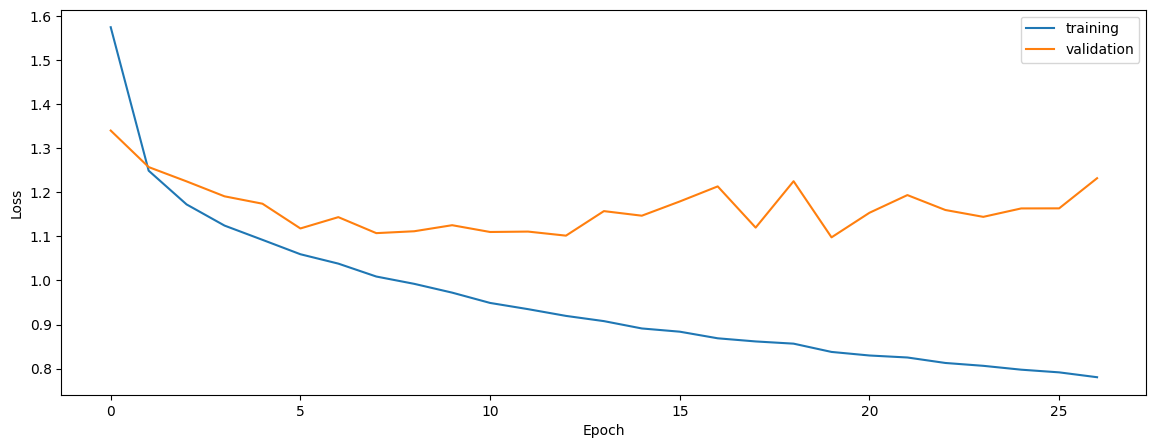

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.676204185123907
0.5585123950885919
0.6248115913842563


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

normalized
0.6738734666599057
0.6103961968290815
0.6036381316593619


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.6726162939530463
0.6168169088148043
0.604267851527045


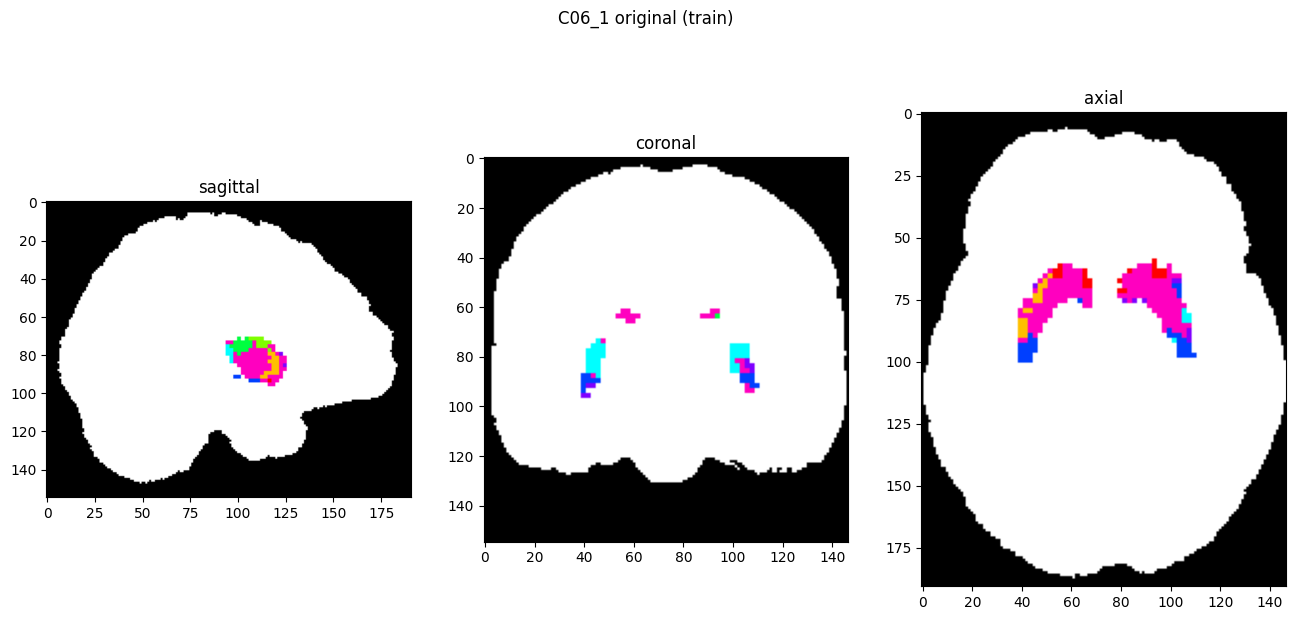

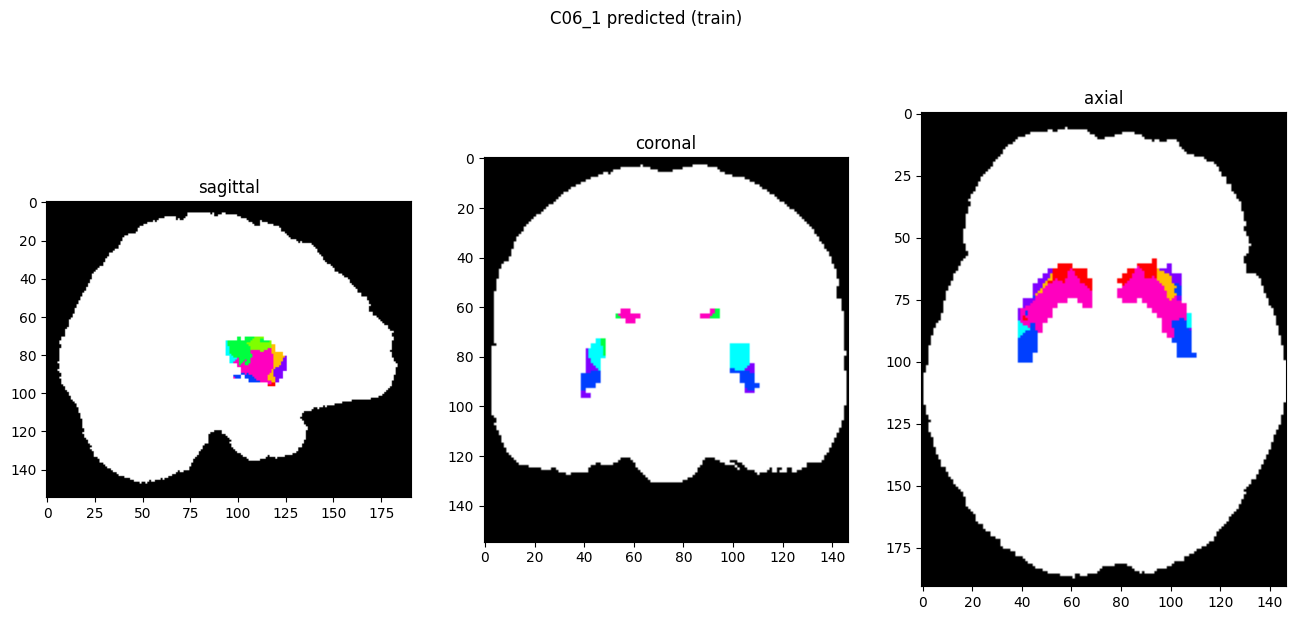

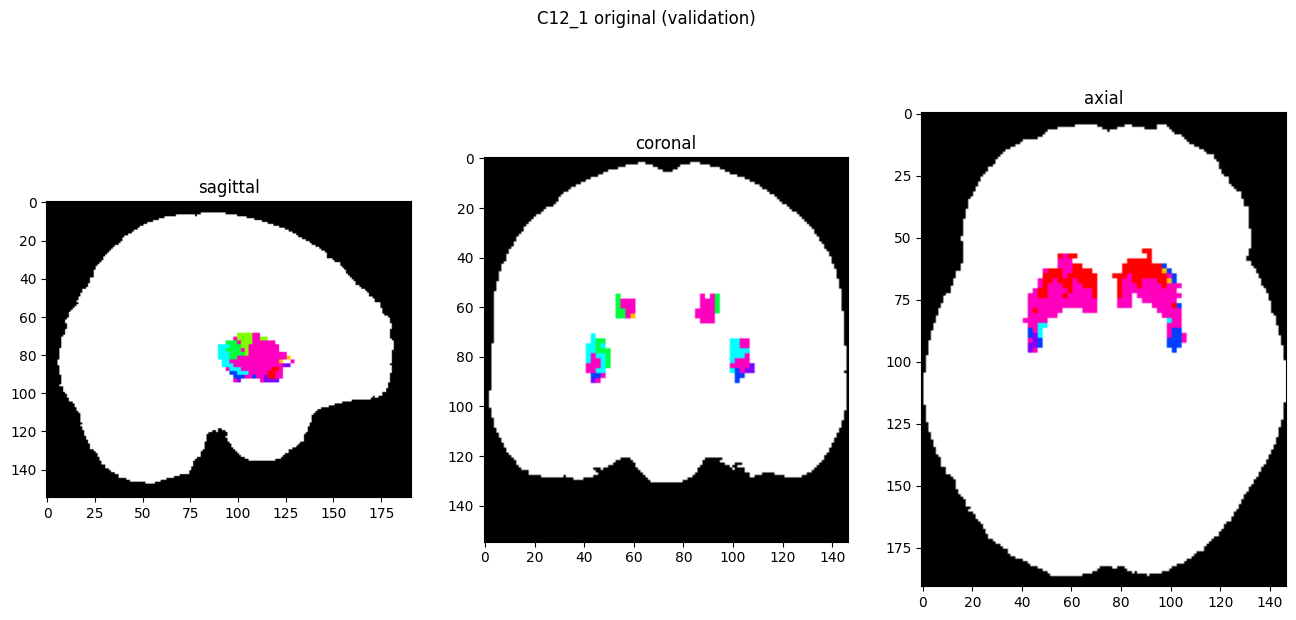

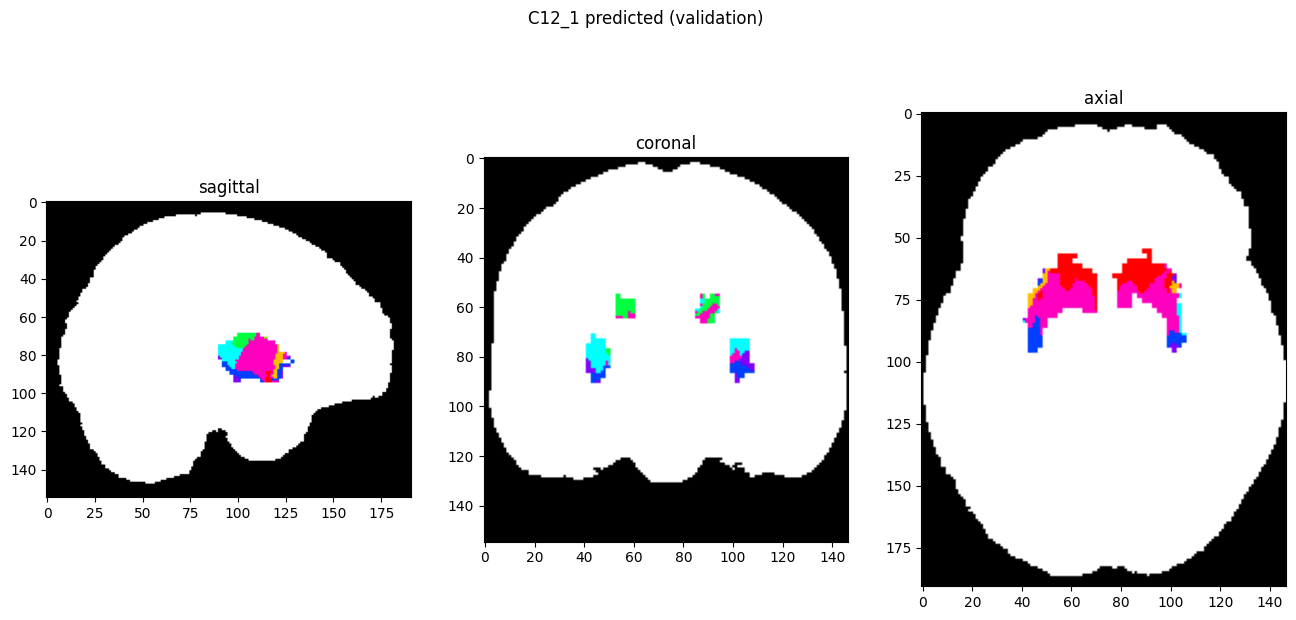

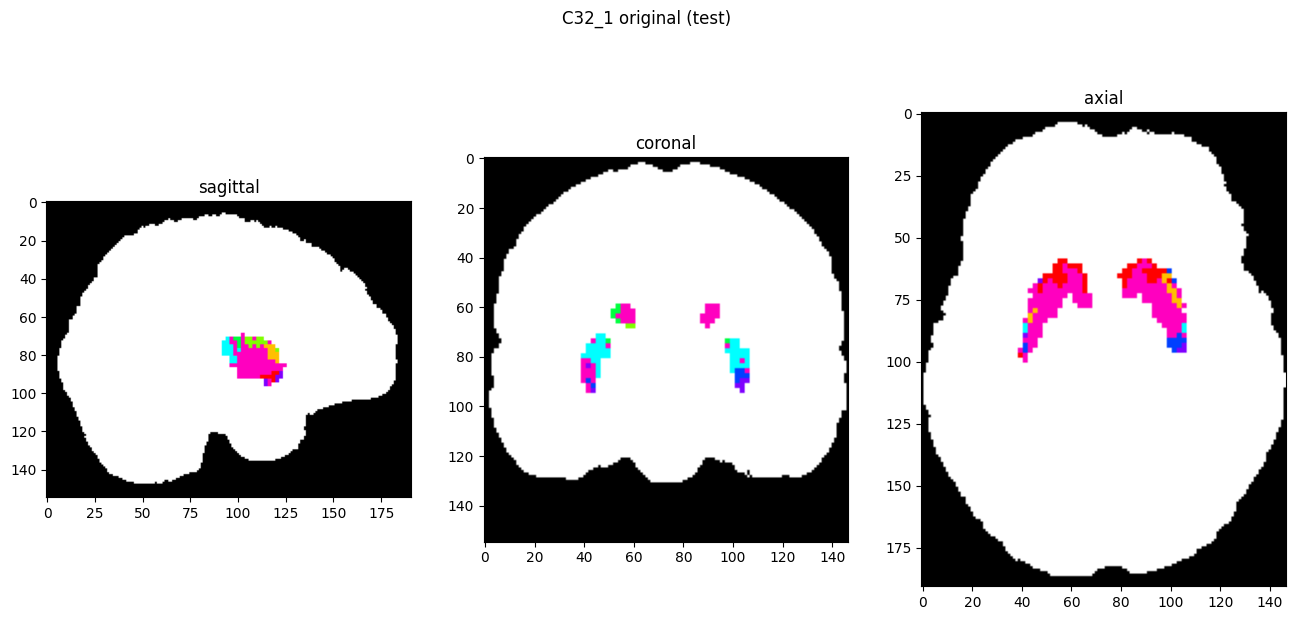

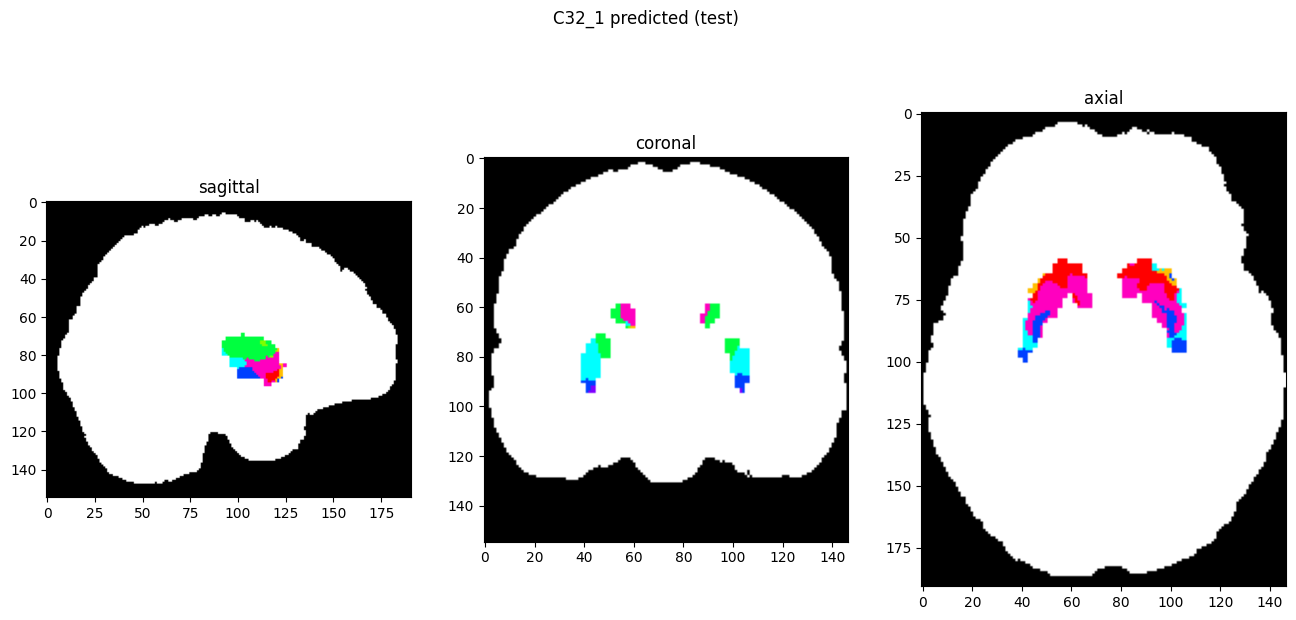

In [10]:
showResults(model, gen, threshold=0)